# Resolving Differeing chemicial identifiers from 3 data-sources

**Caution:** This notebook is a mess.  It was built on a previous pipline where the standard ID was different. It's overdue for a full refactor, but for now it runs ok in the current pipeline. 

Compound identifiers are a mess.  We have 3 different sources of data, each with 3 different primary identifiers... Previously we used CTD (MESH), which also has some ChEBI terms included. Next we looked up records from Inxight Drugs, which happen to use UNII as the primary identifier.  We've converted as many as possilbe to Inchi-key.  Finally, we will be incorporating ReFRAME, which uses Inchi-key as the primary identifier. Many Steps will be required to get maximum overlap from the 3 data Sources.

1. We must resolve mappings from ChEBI to MeSH.
    - ChEBI and MeSH both have tree-like (ontology) structure and many higher-level terms (like chemical classes) are similar
    - Direct mappings between ChEBI and MeSH are difficult to come by
    - The following may have some direct mappings
        - mychem.info
        - wikidata
    - Indirect mappings through other Identifiers may also be useful
2. We need maps from this ChEBI/MeSH to UNII and InchiKey
    - ChEBI to Inchi-key is well definied 
    - inchikey to unii is only somewhat defined, large percnetage missing
3. String Matching will be usd as a last resort
    

In [1]:
%matplotlib inline
import pickle
import zipfile
import pandas as pd
import seaborn as sns
from pathlib import Path
from itertools import chain
import matplotlib.pyplot as plt

from data_tools import graphs as gt
from data_tools.files import load_api_results, download
from data_tools.plotting import venn2_pretty, venn3_pretty
from data_tools.wiki import execute_sparql_query, get_curi_xrefs
from data_tools.obo_processing import get_ontology_edges, get_ontology_nodes, get_children_map
from data_tools.df_processing import expand_col_on_char, expand_split_col, expand_df_on_col, \
                                     combine_group_cols_on_char, char_combine_frame
import tools.biothings_processing as bp

/home/mmayers/software/miniconda3/envs/ml/lib/python3.7/site-packages/data_tools/df_processing.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
# Get Data Dir
data_dir = Path('../2_pipeline/00_download_data/out/').resolve()

# Get Output Directory ready
this_file = '07b_Resolving_Chemical_Identifiers'
out_dir = Path('../2_pipeline/').resolve()
out_dir = out_dir.joinpath(this_file).joinpath('out')

if not out_dir.exists():
    out_dir.mkdir(parents=True)

In [3]:
ix_nodes = pd.read_csv('../2_pipeline/07a_NCATS_Inxight_Drugs_DB_and_DC/out/nodes_inxight.csv', dtype=str)
ix_nodes.head(2)

,id,name,label,ikey,chebi_id,chembl_id,drugbank_id,unii_id,mesh_id,source,doid,meshid,xrefs,curi
0,FZERHIULMFGESH-UHFFFAOYSA-N,Acetanilide,Compound,FZERHIULMFGESH-UHFFFAOYSA-N,CHEBI:28884,CHEMBL269644,NaN,SP86R356CC,MESH:C508827,ikey,NaN,NaN,NaN,NaN
1,SWMPGCCDXNLPED-NSCUHMNNSA-N,Acetylfuratrizine,Compound,SWMPGCCDXNLPED-NSCUHMNNSA-N,NaN,NaN,NaN,C50C4V19SU,MESH:C005910,ikey,NaN,NaN,NaN,NaN


In [4]:
curi_map = {'ikey': 'IKEY', 'chembl_id': 'CHEMBL', 'drugbank_id': 'DB', 'unii_id': 'UNII',
            'wikidata_itg': 'WD', 'wikidata_inf': 'WD'}

def add_curis(df, curi_map):
    for col in set(df.columns)&set(curi_map.keys()):
        multi_col = df[col].str.contains('|', regex=False).fillna(False)
        multi_idx = multi_col[multi_col].index
        single_idx = multi_col[~multi_col].index
        
        df.loc[single_idx, col] = curi_map[col] + ':' + df.loc[single_idx, col]
        df.loc[multi_idx, col] = df.loc[multi_idx, col].apply(lambda x: '|'.join(sorted([
                                                        curi_map[col] + ':' + i for i in x.split('|')])))
    return df

In [5]:
ix_nodes = add_curis(ix_nodes, curi_map)

In [6]:
comp_cols = ['id', 'name', 'label', 'chebi_id', 'chembl_id', 'drugbank_id', 'ikey', 'mesh_id', 'unii_id', 'source']
ix_comps = ix_nodes.query('label == "Compound"').loc[:,comp_cols]
len(ix_comps)

110526

In [7]:
prev_nodes = pd.read_csv('../2_pipeline/06_HPO_Annotations/out/nodes.csv', dtype=str)
prev_comps = prev_nodes.query('label == "Compound"').copy()

prev_comps.head(2)

,id,name,label,xrefs
52932,CHEBI:10,(+)-Atherospermoline,Compound,CHEBI:10|CHEMBL:CHEMBL500609|KEGG:C11141|PCID:...
52933,CHEBI:100,(-)-medicarpin,Compound,CHEBI:100|KEGG:C10503|PCID:336327|UNII:6TX086I6IG


In [8]:
prev_comps['id'].apply(lambda s: s.split(':')[0]).value_counts()

CHEBI     89481
PCID      67450
WD        58786
UNII      31229
CHEMBL    21021
DB         2166
MESH         43
KEGG         17
UMLS          1
IKEY          1
Name: id, dtype: int64

In [9]:
ref = pd.read_csv('../0_data/manual/reframe_merged.csv', dtype=str)
ref = ref.drop_duplicates().reset_index(drop=True)
ref.head(2)

,gvk_id,drug_name,phase,drug_roa,category,mechanism,sub_smiles,synonyms_gvk,ikey,name_inf,...,id,status,smiles_itg,name_itg,integrity_note,int_thera_group,int_MoA,wikidata_itg,PubChem CID,source
0,5916161.0,A-49816,Clinical Phase Unknown,NaN,High-Ceiling Diuretic,High-Ceiling Diuretic,Cl[H].[H]OC1=C(CN([H])[H])C=C(C=C1)C(=O)C2=CC=...,Abbott-49816,WYFYYAHANZQLGG-UHFFFAOYSA-N,NaN,...,145141.0,Clinical,CCOC(=O)COc1ccc(c(c1Cl)Cl)C(=O)c2ccc(c(c2)CN)O.Cl,A-49816,NaN,Diuretics,NaN,Q27270440,CID92009045,gvk|integrity
1,5913712.0,Elmustine,Clinical Phase Unknown,NaN,Anticancer,Anticancer,[H]OCCN([H])C(=O)N(CCCl)N=O,BRN-1956525|FFC-33|HECNU|Hecnu|NSC-294895,YJZJEQBSODVMTH-UHFFFAOYSA-N,Elmustine,...,91016.0,Phase III,C(CO)NC(=O)N(CCCl)N=O,Elmustine,NaN,Oncolytic Drugs,DNA-Damaging Drugs,Q27284767,CID68804,gvk|informa|integrity


In [10]:
ref = add_curis(ref, curi_map)
ikey_to_wd = ref.groupby('ikey')[['wikidata_inf', 'wikidata_itg']].apply(char_combine_frame).replace('', float('nan')).dropna()

In [11]:
len(ref)

17220

Look at how much overlap we have without doing a ton of ID resolution...

In [12]:
ref_ikeys = ref['ikey'].unique()
res = load_api_results(out_dir.joinpath('reframe_mychem_info_{}.pkl'), scrape_function=bp.download_mychem_ids, 
                         chem_ids=ref_ikeys)


ref_comps = bp.process_chemicals_in_mychem_results(res)

In [13]:
source_curi_map = {k.replace('_id', ''): v for k, v in curi_map.items()}

ref_comps = add_curis(ref_comps, curi_map)
ref_comps['id'] = ref_comps['source'].map(source_curi_map) + ':' + ref_comps['id']

In [14]:
ref_comps

,q,ikey,chebi_id,chembl_id,drugbank_id,unii_id,mesh_id,name,id,source
0,WYFYYAHANZQLGG-UHFFFAOYSA-N,IKEY:WYFYYAHANZQLGG-UHFFFAOYSA-N,NaN,CHEMBL:CHEMBL543295,NaN,UNII:8GKF50WX7S,NaN,A-49816 hydrochloride,IKEY:WYFYYAHANZQLGG-UHFFFAOYSA-N,ikey
1,YJZJEQBSODVMTH-UHFFFAOYSA-N,IKEY:YJZJEQBSODVMTH-UHFFFAOYSA-N,NaN,CHEMBL:CHEMBL284907,NaN,UNII:NAT2FD82D7,MESH:C013876,Elmustine,IKEY:YJZJEQBSODVMTH-UHFFFAOYSA-N,ikey
2,GXCZZAKPGMYPDJ-UHFFFAOYSA-N,IKEY:GXCZZAKPGMYPDJ-UHFFFAOYSA-N,NaN,CHEMBL:CHEMBL18410,NaN,NaN,NaN,NaN,IKEY:GXCZZAKPGMYPDJ-UHFFFAOYSA-N,ikey
3,JBWMXRJDMMPGCX-UHFFFAOYSA-N,IKEY:JBWMXRJDMMPGCX-UHFFFAOYSA-N,NaN,NaN,NaN,NaN,NaN,NaN,IKEY:JBWMXRJDMMPGCX-UHFFFAOYSA-N,ikey
4,MXNZCIQNSJMZST-UHFFFAOYSA-N,IKEY:MXNZCIQNSJMZST-UHFFFAOYSA-N,CHEBI:90193,CHEMBL:CHEMBL2000244,NaN,UNII:79BOD3G8DW,NaN,"2,5-bis(2-hydroxyethylamino)-3,6-diaziridinyl-...",IKEY:MXNZCIQNSJMZST-UHFFFAOYSA-N,ikey
...,...,...,...,...,...,...,...,...,...,...
17086,GFVBDLIBPSGFDL-ZOWNYOTGSA-N,IKEY:GFVBDLIBPSGFDL-ZOWNYOTGSA-N,NaN,NaN,NaN,UNII:UXP39EQ477,NaN,Arazasetron besylate,IKEY:GFVBDLIBPSGFDL-ZOWNYOTGSA-N,ikey
17087,VLRZIRYGLUVGGU-UHFFFAOYSA-N,IKEY:VLRZIRYGLUVGGU-UHFFFAOYSA-N,NaN,NaN,NaN,NaN,NaN,NaN,IKEY:VLRZIRYGLUVGGU-UHFFFAOYSA-N,ikey
17088,OGBDDOBYHJYBFF-UHFFFAOYSA-N,IKEY:OGBDDOBYHJYBFF-UHFFFAOYSA-N,NaN,CHEMBL:CHEMBL2324748,NaN,NaN,NaN,NaN,IKEY:OGBDDOBYHJYBFF-UHFFFAOYSA-N,ikey
17089,ZAGGUCLXSCVDCK-UHFFFAOYSA-N,IKEY:ZAGGUCLXSCVDCK-UHFFFAOYSA-N,NaN,CHEMBL:CHEMBL2324776,NaN,NaN,NaN,NaN,IKEY:ZAGGUCLXSCVDCK-UHFFFAOYSA-N,ikey


In [15]:
ref_comps['wd_id'] = ref_comps['ikey'].map(ikey_to_wd)


In [16]:
ref_comps.head(2)

,q,ikey,chebi_id,chembl_id,drugbank_id,unii_id,mesh_id,name,id,source,wd_id
0,WYFYYAHANZQLGG-UHFFFAOYSA-N,IKEY:WYFYYAHANZQLGG-UHFFFAOYSA-N,NaN,CHEMBL:CHEMBL543295,NaN,UNII:8GKF50WX7S,NaN,A-49816 hydrochloride,IKEY:WYFYYAHANZQLGG-UHFFFAOYSA-N,ikey,WD:Q27270440
1,YJZJEQBSODVMTH-UHFFFAOYSA-N,IKEY:YJZJEQBSODVMTH-UHFFFAOYSA-N,NaN,CHEMBL:CHEMBL284907,NaN,UNII:NAT2FD82D7,MESH:C013876,Elmustine,IKEY:YJZJEQBSODVMTH-UHFFFAOYSA-N,ikey,WD:Q27284767


In [17]:
len(ref_comps)

17091

In [18]:
# how many returned at least SOME kind of result?
len(ref_comps.drop('q', axis=1).dropna(how='all'))

14848

In [19]:
inchi_to_mesh = expand_col_on_char(ref_comps, 'mesh_id', '|').dropna(subset=['ikey']).set_index('ikey')['mesh_id'].to_dict()
inchi_to_mesh = {**expand_col_on_char(ix_comps, 'mesh_id', '|').dropna(subset=['ikey']).set_index('ikey')['mesh_id'].to_dict(), **inchi_to_mesh}

In [20]:
chebi = get_ontology_nodes(data_dir.joinpath('chebi.obo'), props=['http://purl.obolibrary.org/obo/chebi/inchikey'])
chebi = chebi.rename(columns={'http://purl.obolibrary.org/obo/chebi/inchikey': 'ikey'})
chebi.head(2)

,subset,id,name,def,xref,ikey,alt_id,is_obsolete,id_src
0,3_STAR,CHEBI:24431,chemical entity,"""A chemical entity is a physical entity of int...",NaN,NaN,NaN,False,CHEBI
1,3_STAR,CHEBI:23367,molecular entity,"""Any constitutionally or isotopically distinct...",NaN,NaN,NaN,False,CHEBI


In [21]:
inchi_to_chebi = chebi.dropna(subset=['ikey']).set_index('ikey')['id'].to_dict()
inchi_to_chebi = {**expand_col_on_char(ref_comps, 'chebi_id', '|').dropna(subset=['ikey']).set_index('ikey')['chebi_id'].to_dict(), **inchi_to_chebi}
inchi_to_chebi = {**expand_col_on_char(ix_comps, 'chebi_id', '|').dropna(subset=['ikey']).set_index('ikey')['chebi_id'].to_dict(), **inchi_to_chebi}

In [22]:
prev_comp_ids = set(prev_comps['id'])
ref_comp_ids = set(ref_comps['ikey'].map(inchi_to_chebi).fillna(ref_comps['ikey'].map(inchi_to_mesh)).fillna(ref_comps['id']))
ix_comp_ids = set(ix_comps['ikey'].map(inchi_to_chebi).fillna(ix_comps['ikey'].map(inchi_to_mesh)).fillna(ix_comps['id']))

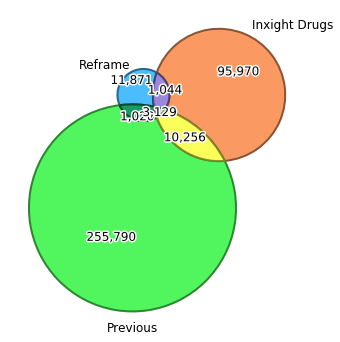

In [23]:
plt.figure(figsize=(10,6))
venn3_pretty([ref_comp_ids, ix_comp_ids, prev_comp_ids], ['Reframe', 'Inxight Drugs', 'Previous'])

In [24]:
len(chebi.dropna(subset=['ikey']))

92700

### Wikidata to query chebi to mesh

In [25]:
query = """
SELECT DISTINCT ?chebi ?mesh ?item ?itemLabel
WHERE 
{
  ?item wdt:P486 ?mesh.
  ?item wdt:P683 ?chebi.
  SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". }
}
ORDER BY ?itemLabel
"""

In [26]:
chebi_to_mesh = execute_sparql_query(query)

In [27]:
chebi_to_mesh

,chebi,mesh,item,itemLabel
0,64117,C051171,Q27074361,(+)-AJ76
1,109533,D002069,Q5002336,(+)-butaclamol
2,63937,C080462,Q27076939,(+)-cyclazosin
3,4803,C082748,Q423783,(+)-epibatidine
4,36,D010665,Q413147,(+)-phenylpropanolamine
...,...,...,...,...
5566,10447,C009479,Q2705171,β-thujaplicin
5567,16865,D005680,Q210021,γ-aminobutyric acid
5568,132823,C025473,Q27262523,γ-sitosterol
5569,18185,D024504,Q155753,γ-tocopherol


Descriptor and Supplemental IDs in MeSH start with a C or a D. Some IDs in WikiData start with M which are not the correct namespace

In [28]:
bad_mesh = chebi_to_mesh['mesh'].str.startswith('M')
bad_mesh = bad_mesh[bad_mesh].index
chebi_to_mesh = chebi_to_mesh.drop(bad_mesh)

# Add CURIs
chebi_to_mesh['chebi'] = 'CHEBI:' + chebi_to_mesh['chebi']
chebi_to_mesh['mesh'] = 'MESH:' + chebi_to_mesh['mesh']

In [29]:
c_ix = chebi_to_mesh['mesh'].duplicated(keep=False)
chebi_duped = chebi_to_mesh.loc[c_ix[c_ix].index]
len(chebi_duped)

31

These are instances of multiple CHEBI ids for a single WIKIDATA item... (where that item has at least 1 MESH id)

We will try to resolve these...

In [30]:
m_ix = chebi_to_mesh['chebi'].duplicated(keep=False)
mesh_duped = chebi_to_mesh.loc[m_ix[m_ix].index]
len(mesh_duped)

32

These are instances of a Mutiple MESH ids for a single WIKIDATA item (with at least one CHEBI id).

May be small enought to resolve

### Look at only the 1 to 1 mappings and see if we can merge to chebi ontology

In [31]:
# Not dupilcated chebi AND not duplicated MeSH
no_dup_idx = chebi_to_mesh[(~c_ix & ~m_ix)].index

unique_chebi_to_mesh = chebi_to_mesh.loc[no_dup_idx]
len(unique_chebi_to_mesh)

5508

In [32]:
len(chebi)

113750

Add our MeSH IDs to the Chebi ontology data, as accounting for 1 to 1 mappings

In [33]:
chebi = pd.merge(chebi, unique_chebi_to_mesh[['chebi', 'mesh']], how='left', left_on='id', right_on='chebi').drop('chebi', axis=1)

In [34]:
chebi.dropna(subset=['mesh']).sample(10)

,subset,id,name,def,xref,ikey,alt_id,is_obsolete,id_src,mesh
15947,3_STAR,CHEBI:34260,anthracen-2-amine,NaN,"Gmelin:1912207 ""Gmelin""|KEGG:C14417|CAS:613-13...",YCSBALJAGZKWFF-UHFFFAOYSA-N,NaN,False,CHEBI,MESH:C006593
83981,3_STAR,CHEBI:27909,paraldehyde,"""A trioxane that is 1,3,5-trioxane substituted...","Beilstein:80142 ""Beilstein""|KEGG:D00705|Wikipe...",SQYNKIJPMDEDEG-UHFFFAOYSA-N,CHEBI:7920|CHEBI:25854,False,CHEBI,MESH:D010242
82459,2_STAR,CHEBI:135075,alphaprodine,NaN,"CAS:77-20-3 ""DrugCentral""|Drug_Central:132 ""Dr...",UVAZQQHAVMNMHE-XJKSGUPXSA-N,NaN,False,CHEBI,MESH:D000522
113550,3_STAR,CHEBI:75050,chromogenic compound,"""Colourless, endogenous or exogenous pigment p...",NaN,NaN,NaN,False,CHEBI,MESH:D002863
99673,2_STAR,CHEBI:135795,loperamide oxide,NaN,"CAS:106900-12-3 ""DrugCentral""|Drug_Central:160...",KXVSBTJVTUVNPM-UKPNQBOSSA-N,NaN,False,CHEBI,MESH:C066043
95905,2_STAR,CHEBI:134972,flosequinan,NaN,"CAS:76568-02-0 ""DrugCentral""|Drug_Central:1182...",UYGONJYYUKVHDD-UHFFFAOYSA-N,NaN,False,CHEBI,MESH:C047316
24915,3_STAR,CHEBI:6762,mepyramine,"""An ethylenediamine derivative that is ethyle...","CAS:91-84-9 ""KEGG COMPOUND""|KEGG:C11798|PMID:2...",YECBIJXISLIIDS-UHFFFAOYSA-N,NaN,False,CHEBI,MESH:D011738
71752,3_STAR,CHEBI:44975,"1,10-phenanthroline",NaN,DrugBank:DB02365|Wikipedia:Phenanthroline|PMID...,DGEZNRSVGBDHLK-UHFFFAOYSA-N,CHEBI:476|CHEBI:44973,False,CHEBI,MESH:C025205
24376,3_STAR,CHEBI:101278,diltiazem,"""A 5-[2-(dimethylamino)ethyl]-2-(4-methoxyphen...","LINCS:LSM-2523|CAS:42399-41-7 ""ChemIDplus""|Pat...",HSUGRBWQSSZJOP-RTWAWAEBSA-N,CHEBI:4602,False,CHEBI,MESH:D004110
40279,3_STAR,CHEBI:76162,indoprofen,"""A monocarboxylic acid that is propionic acid ...","PMID:22282415 ""Europe PMC""|PMID:378745 ""Europe...",RJMIEHBSYVWVIN-UHFFFAOYSA-N,NaN,False,CHEBI,MESH:D007216


In [35]:
chebi_ids = chebi['id'].unique()

In [36]:
# Any from Wiki weren't in Chebi?
len(unique_chebi_to_mesh.query('chebi not in @chebi_ids'))

8

Chebi has Alternate IDs, some of which are also ChEBI ids.. Determine if some of these account for our missing IDs

In [37]:
chebi_alt_ids = set(('|'.join(chebi['alt_id'].dropna().values)).split('|'))
# Any duplicated Alt-Ids?
len(chebi_alt_ids) != len(('|'.join(chebi['alt_id'].dropna().values)).split('|'))

False

In [38]:
len(chebi_alt_ids)

18332

In [39]:
unique_chebi_to_mesh.query('chebi not in @chebi_ids and chebi not in @chebi_alt_ids')

,chebi,mesh,item,itemLabel
602,CHEBI:231177,MESH:D005017,Q426269,Ethyl biscoumacetate
901,CHEBI:1201724,MESH:D011206,Q241516,Povidone-iodine
2437,CHEBI:144353,MESH:D004050,Q27093504,ditiocarb
2686,CHEBI:553487,MESH:C015208,Q5404861,etozoline
3207,CHEBI:345108,MESH:C034204,Q6015692,indanidine
3373,CHEBI:1201185,MESH:C060347,Q1707877,lanreotide
3894,CHEBI:144804,MESH:C017557,Q13896593,nickel subsulfide
5295,CHEBI:144441,MESH:C034613,Q7839870,triacsin c


All just don't exist... in either full chebi or the alternate ids... Still, lets get a map from the alternate ids

In [40]:
alt_to_standard_chebi = chebi.dropna(subset=['alt_id']).set_index('alt_id')['id'].to_dict()
len(alt_to_standard_chebi)

7513

Some alternate ids are multiple ChEBIs e.g. `'CHEBI:569|CHEBI:18963|CHEBI:11189'` so split those out into separate mappings

In [41]:
alt_to_standard_chebi = {k: v for ks, v in alt_to_standard_chebi.items() for k in ks.split('|') }
len(alt_to_standard_chebi)

18332

#### Generation of chebi to mesh dict

We really are interested in the 1 to 1 mappings (chebi should be a bit more specific than MeSH so in the Chebi to Mesh direction, we should be able to do 1 to 1 for most items)

In [42]:
chebi_to_mesh_dict = (unique_chebi_to_mesh.query('chebi not in @chebi_ids')
                      .set_index('mesh')['chebi']
                      .map(alt_to_standard_chebi)
                      .dropna()
                      .to_dict())
chebi_to_mesh_dict = {v: k for k, v in chebi_to_mesh_dict.items()}

In [43]:
len(chebi_to_mesh_dict)

0

In [44]:
before = chebi['mesh'].count()
before

5500

In [45]:
chebi['mesh'] = chebi['mesh'].fillna(chebi['id'].map(chebi_to_mesh_dict))
after = chebi['mesh'].count()
after - before

0

### The 36 Chebi items that have multiple chebi ids...

In [46]:
chebi_duped.head(2)

,chebi,mesh,item,itemLabel
410,CHEBI:49167,MESH:D018927,Q50430265,Anti-Asthmatic Agents
411,CHEBI:65023,MESH:D018927,Q50430265,Anti-Asthmatic Agents


In [47]:
chebi_duped['item'].nunique()

16

In [48]:
chebi_duped['new_chebi'] = chebi_duped['chebi'].map(alt_to_standard_chebi)
chebi_duped['new_chebi'].count()

0

none mapped thorugh alternate ids..

In [49]:
chebi_duped['new_chebi'] = chebi_duped['new_chebi'].fillna(chebi_duped['chebi'])
chebi_duped['new_chebi'].nunique()

31

In [50]:
in_ontology = pd.merge(chebi_duped, chebi, how='inner', left_on='new_chebi', right_on='id')
in_ontology['new_chebi'].nunique(), in_ontology['item'].nunique()

(31, 16)

Still more chebi ids than wikidata items... and all can be mapped to the ontology!

In [51]:
in_ontology.drop_duplicates(subset=['new_chebi', 'item', 'mesh_x']).nunique()

chebi          31
mesh_x         15
item           16
itemLabel      16
new_chebi      31
subset          2
id             31
name           31
def            29
xref           22
ikey           13
alt_id          7
is_obsolete     1
id_src          1
mesh_y          0
dtype: int64

In [52]:
in_ontology = in_ontology.drop_duplicates(subset=['new_chebi', 'item', 'mesh_x'])

In [53]:
new_1t1 = (in_ontology.drop_duplicates(subset=['mesh_x'], keep=False)
                .drop_duplicates(subset=['new_chebi'], keep=False))
len(new_1t1)

0

great... nothing has a 1 to 1 mapping (everything is duplicated)

In [54]:
chebi_to_mesh_dict = new_1t1.set_index('new_chebi')['mesh_x'].to_dict()

In [55]:
# See some duplicated MeSH IDs for some unique CHEBI IDs...
duped = in_ontology[in_ontology['mesh_x'].duplicated()]['mesh_x'].sample(10).values
in_ontology.query('mesh_x in @duped').sort_values('mesh_x')[['itemLabel', 'name', 'mesh_x', 'id']]

,itemLabel,name,mesh_x,id
4,N(5)-hydroxy-L-ornithine,N(5)-hydroxy-L-ornithine,MESH:C004976,CHEBI:79095
5,N(5)-hydroxy-L-ornithine,N(5)-hydroxy-L-ornithine zwitterion,MESH:C004976,CHEBI:78275
16,glycine,glycine zwitterion,MESH:D005998,CHEBI:57305
15,glycine,glycine,MESH:D005998,CHEBI:15428
18,indans,indanes,MESH:D007189,CHEBI:46940
17,indane,indane,MESH:D007189,CHEBI:37911
19,mimosine,L-mimosine,MESH:D008898,CHEBI:29063
20,mimosine,L-mimosine zwitterion,MESH:D008898,CHEBI:77689
23,neostigmine,neostigmine methyl sulfate,MESH:D009388,CHEBI:7516
24,neostigmine,neostigmine,MESH:D009388,CHEBI:7514


We'll keep this one to many relationship...

In [56]:
found = list(chebi_to_mesh_dict.keys())
chebi_to_mesh_dict.update(in_ontology.query('new_chebi not in @found')
                                     .drop_duplicates(subset=['new_chebi'], keep=False)
                                     .set_index('new_chebi')['mesh_x']
                                     .to_dict())

In [57]:
# Examine where chebi ids are duplicated.... (but potentially uniqe items or mesh_ids...)
(in_ontology[in_ontology['new_chebi'].duplicated(keep=False)]   
 .sort_values('new_chebi')[['itemLabel', 'name', 'new_chebi', 'mesh_x', 'item']])

,itemLabel,name,new_chebi,mesh_x,item


- Vitamin C and asorbic acid are same... don't know why wikidata consideres them different...

- Insoine 
    - D007288 - Correct...
    - D007292	Inosine Nucleotides

- Guanidine
    - D019791 is correct
    - D006146 is the class of compounds.... (Guanidines)

In [58]:
chebi_to_mesh_dict['CHEBI:42820'] = 'MESH:D019791'
chebi_to_mesh_dict['CHEBI:17596'] = 'MESH:D007288'

In [59]:
len(chebi_to_mesh_dict)

33

In [60]:
before = chebi['mesh'].count()
before

5500

In [61]:
chebi['mesh'] = chebi['mesh'].fillna(chebi['id'].map(chebi_to_mesh_dict))
after = chebi['mesh'].count()
after - before

31

2 Didn't map, but for now we're about as good was we can get from WikiData

In [62]:
chebi.dropna(subset=['mesh']).sample(20)

,subset,id,name,def,xref,ikey,alt_id,is_obsolete,id_src,mesh
109343,3_STAR,CHEBI:25901,pentose,"""A five-carbon monosaccharide which in its lin...",NaN,NaN,NaN,False,CHEBI,MESH:D010429
108736,3_STAR,CHEBI:7508,framycetin,"""A tetracyclic antibacterial agent derived fro...","Drug_Central:1896 ""DrugCentral""|PMID:25588492 ...",PGBHMTALBVVCIT-VCIWKGPPSA-N,CHEBI:44577,False,CHEBI,MESH:D005601
33041,3_STAR,CHEBI:15996,GTP,NaN,"Beilstein:1201437 ""ChemIDplus""|KNApSAcK:C00007...",XKMLYUALXHKNFT-UUOKFMHZSA-N,CHEBI:24451|CHEBI:13342|CHEBI:42934|CHEBI:5234,False,CHEBI,MESH:D006160
39890,3_STAR,CHEBI:51208,mecillinam,"""A penicillin in which the 6beta substituent i...",Patent:US3957764|LINCS:LSM-5528|CAS:32887-01-7...,BWWVAEOLVKTZFQ-NTZNESFSSA-N,NaN,False,CHEBI,MESH:D000560
112840,3_STAR,CHEBI:50185,fatty acid synthesis inhibitor,"""Any pathway inhibitor that inhibits the synth...",NaN,NaN,NaN,False,CHEBI,MESH:D054872
14754,3_STAR,CHEBI:49770,methyl red,"""An azo dye consisting of benzoic acid substit...",Wikipedia:Methyl_red|KEGG:C19459|Reaxys:750102...,CEQFOVLGLXCDCX-WUKNDPDISA-N,NaN,False,CHEBI,MESH:C008492
10952,3_STAR,CHEBI:46020,tetramethylammonium,"""The simplest quaternary ammonium cation, comp...","Reaxys:1733140 ""Reaxys""|DrugBank:DB03095|PMID:...",QEMXHQIAXOOASZ-UHFFFAOYSA-N,CHEBI:46018|CHEBI:35264,False,CHEBI,MESH:C027917
104032,3_STAR,CHEBI:75377,phenyl biguanide,"""A member of the class of biguanides that is b...","CAS:102-02-3 ""NIST Chemistry WebBook""|LINCS:LS...",CUQCMXFWIMOWRP-UHFFFAOYSA-N,NaN,False,CHEBI,MESH:C008846
32994,3_STAR,CHEBI:15751,ADP alpha-D-glucoside,"""An ADP-aldose having alpha-D-glucopyranose as...",HMDB:HMDB0006557|ECMDB:ECMDB06557|PMID:2353732...,WFPZSXYXPSUOPY-ROYWQJLOSA-N,CHEBI:13230|CHEBI:20846|CHEBI:2349|CHEBI:40615,False,CHEBI,MESH:D000245
101578,2_STAR,CHEBI:80271,Glucagon-like peptide 2,NaN,KEGG:C16049,NaN,NaN,False,CHEBI,MESH:D053767


# Look at previous MyChem Results...

In [63]:
ref_comps.head(2)

,q,ikey,chebi_id,chembl_id,drugbank_id,unii_id,mesh_id,name,id,source,wd_id
0,WYFYYAHANZQLGG-UHFFFAOYSA-N,IKEY:WYFYYAHANZQLGG-UHFFFAOYSA-N,NaN,CHEMBL:CHEMBL543295,NaN,UNII:8GKF50WX7S,NaN,A-49816 hydrochloride,IKEY:WYFYYAHANZQLGG-UHFFFAOYSA-N,ikey,WD:Q27270440
1,YJZJEQBSODVMTH-UHFFFAOYSA-N,IKEY:YJZJEQBSODVMTH-UHFFFAOYSA-N,NaN,CHEMBL:CHEMBL284907,NaN,UNII:NAT2FD82D7,MESH:C013876,Elmustine,IKEY:YJZJEQBSODVMTH-UHFFFAOYSA-N,ikey,WD:Q27284767


In [64]:
prev_comps.head(2)

,id,name,label,xrefs
52932,CHEBI:10,(+)-Atherospermoline,Compound,CHEBI:10|CHEMBL:CHEMBL500609|KEGG:C11141|PCID:...
52933,CHEBI:100,(-)-medicarpin,Compound,CHEBI:100|KEGG:C10503|PCID:336327|UNII:6TX086I6IG


In [65]:
ix_comps.head(2)

,id,name,label,chebi_id,chembl_id,drugbank_id,ikey,mesh_id,unii_id,source
0,FZERHIULMFGESH-UHFFFAOYSA-N,Acetanilide,Compound,CHEBI:28884,CHEMBL:CHEMBL269644,NaN,IKEY:FZERHIULMFGESH-UHFFFAOYSA-N,MESH:C508827,UNII:SP86R356CC,ikey
1,SWMPGCCDXNLPED-NSCUHMNNSA-N,Acetylfuratrizine,Compound,NaN,NaN,NaN,IKEY:SWMPGCCDXNLPED-NSCUHMNNSA-N,MESH:C005910,UNII:C50C4V19SU,ikey


In [66]:
prev_comps['curi'] = prev_comps['id'].str.split(':', expand=True)[0]
prev_comps.query('curi == "CHEBI"').head(10)

,id,name,label,xrefs,curi
52932,CHEBI:10,(+)-Atherospermoline,Compound,CHEBI:10|CHEMBL:CHEMBL500609|KEGG:C11141|PCID:...,CHEBI
52933,CHEBI:100,(-)-medicarpin,Compound,CHEBI:100|KEGG:C10503|PCID:336327|UNII:6TX086I6IG,CHEBI
52934,CHEBI:10000,Vismione D,Compound,CHEBI:10000|CHEMBL:CHEMBL487795|KEGG:C09977|PC...,CHEBI
52935,CHEBI:100000,"(2S,3S,4R)-3-[4-(3-cyclopentylprop-1-ynyl)phen...",Compound,CHEBI:100000|PCID:54650119,CHEBI
52936,CHEBI:100001,"N-[(2R,3S,6R)-2-(hydroxymethyl)-6-[2-[[oxo-[4-...",Compound,CHEBI:100001|PCID:54638612,CHEBI
52937,CHEBI:100002,"3-chloro-N-[(5S,6S,9S)-5-methoxy-3,6,9-trimeth...",Compound,CHEBI:100002|PCID:54632133,CHEBI
52938,CHEBI:100003,"(4R,7S,8R)-8-methoxy-4,7,10-trimethyl-11-oxo-1...",Compound,CHEBI:100003|PCID:54631962,CHEBI
52939,CHEBI:100004,"1-(2,5-difluorophenyl)-3-[(5S,6S,9S)-5-methoxy...",Compound,CHEBI:100004|PCID:54631371,CHEBI
52940,CHEBI:100005,"N-[(1S,3S,4aS,9aR)-1-(hydroxymethyl)-3-[2-oxo-...",Compound,CHEBI:100005|PCID:54646559,CHEBI
52941,CHEBI:100006,"N-(1,3-benzodioxol-5-ylmethyl)-2-[(2R,3R,6S)-3...",Compound,CHEBI:100006|PCID:54638262,CHEBI


this step of the pipeline requires a separate column for each identifier, so let's set that up

In [67]:
prev_db = get_curi_xrefs(prev_nodes, 'DB')
prev_mesh = get_curi_xrefs(prev_nodes, 'MESH')
prev_cheb = get_curi_xrefs(prev_nodes, 'CHEBI')

prev_comps = prev_comps.merge(prev_db, on='id', how='left', suffixes=('', '_new')).rename(columns={'xrefs_new': 'drugbank_id'})
prev_comps = prev_comps.merge(prev_mesh, on='id', how='left', suffixes=('', '_new')).rename(columns={'xrefs_new': 'mesh_id'})
prev_comps = prev_comps.merge(prev_cheb, on='id', how='left', suffixes=('', '_new')).rename(columns={'xrefs_new': 'chebi_id'})

In [68]:
prev_comps.head(2)

,id,name,label,xrefs,curi,drugbank_id,mesh_id,chebi_id
0,CHEBI:10,(+)-Atherospermoline,Compound,CHEBI:10|CHEMBL:CHEMBL500609|KEGG:C11141|PCID:...,CHEBI,NaN,NaN,CHEBI:10
1,CHEBI:100,(-)-medicarpin,Compound,CHEBI:100|KEGG:C10503|PCID:336327|UNII:6TX086I6IG,CHEBI,NaN,NaN,CHEBI:100


Need to do a grouby on ID and join with Pipe to match the ref_comps and ix_comps results.

In [69]:
prev_comps = combine_group_cols_on_char(prev_comps, ['id'], ['mesh_id', 'chebi_id'], sort=True, prog=False)

In [70]:
(prev_comps == "").sum()

id               0
name             0
label            0
xrefs            0
curi             0
drugbank_id      0
mesh_id        260
chebi_id         2
dtype: int64

In [71]:
# Somehow some nan values became empty strings... fix now
prev_comps = prev_comps.replace('', float('nan'))

In [72]:
cs = ['chebi_id', 'mesh_id', 'drugbank_id', 'name']

prev_res = pd.concat([ref_comps.dropna(subset=['chebi_id', 'mesh_id']),ix_comps.dropna(subset=['chebi_id', 'mesh_id']),
          prev_comps.dropna(subset=['chebi_id', 'mesh_id'], how='any')[cs]],
          ignore_index=True, sort=False)

In [73]:
prev_res = expand_col_on_char(prev_res, 'mesh_id', '|')
prev_res = expand_col_on_char(prev_res, 'chebi_id', '|')

Make triple sure all mesh IDs are ok, and get rid of the ones that arent.

In [74]:
bad_mesh = (~(prev_res['mesh_id'].str.split(':', expand=True)[1].str.startswith('C')) & 
            ~(prev_res['mesh_id'].str.split(':', expand=True)[1].str.startswith('D')))

prev_res[bad_mesh]

,q,ikey,chebi_id,chembl_id,drugbank_id,unii_id,mesh_id,name,id,source,wd_id,label
13557,NaN,NaN,CHEBI:2675,NaN,DB:00543,NaN,MESH:T001967,amoxapine,NaN,NaN,NaN,NaN
13563,NaN,NaN,CHEBI:31527,NaN,DB:00378,NaN,MESH:T013405,dydrogesterone,NaN,NaN,NaN,NaN
13576,NaN,NaN,CHEBI:46195,NaN,DB:00316,NaN,MESH:T000213,acetaminophen,NaN,NaN,NaN,NaN


In [75]:
prev_res = prev_res.drop(bad_mesh[bad_mesh].index)

In [76]:
len(prev_res)

13618

Could be some duplicates

In [77]:
prev_res = prev_res.dropna(subset=['chebi_id', 'mesh_id']).drop_duplicates(subset=['chebi_id', 'mesh_id'])
len(prev_res)

8177

In [78]:
c_dup = prev_res.duplicated(subset=['chebi_id'], keep=False)
m_dup = prev_res.duplicated(subset=['mesh_id'], keep=False)

one_2_one = prev_res[(~c_dup & ~m_dup)].copy()
len(one_2_one)

6614

This means about 1500 conflicts within the 3 previous sources themselves....

In [79]:
chebs = set(one_2_one['chebi_id'])
len(chebi.query('id in @chebs')), chebi.query('id in @chebs')['mesh'].count()

(6593, 4038)

In [80]:
c2m_dict = one_2_one.set_index('chebi_id')['mesh_id'].to_dict()

### With different sources for the mapping, there may be some conflict here...

In [81]:
idx = (chebi.query('id in @chebs').dropna(subset=['mesh'])['id'].map(c2m_dict) != 
     chebi.query('id in @chebs').dropna(subset=['mesh'])['mesh'])
idx.sum()

4

Actually, the mappings are fairly consistnet...

In [82]:
idx = idx[idx].index
conflict = chebi.loc[idx]
conflict['other_mesh'] = conflict['id'].map(c2m_dict)

In [83]:
if not out_dir.joinpath('MeSH_DescUID_to_Name.pkl').exists():
    
    # Adapted from https://github.com/mmayers12/semmed/blob/master/prepare/04-Parse_MeSH_data.ipynb
    import xml.etree.ElementTree as ET
    from collections import defaultdict
    
    # Download the MESH xml files
    #download('ftp://nlmpubs.nlm.nih.gov/online/mesh/MESH_FILES/xmlmesh/desc2020.xml',
    #         str(out_dir.joinpath('desc2020.xml')))
    #download('ftp://nlmpubs.nlm.nih.gov/online/mesh/MESH_FILES/xmlmesh/supp2020.xml', 
    #         str(out_dir.joinpath('supp2020.xml')))

    # Load them into memory
    root = ET.parse(out_dir.joinpath('desc2020.xml')).getroot()
    root1 = ET.parse(out_dir.joinpath('supp2020.xml')).getroot()
    
    # Start make a mesh id to name dictionary
    m2name = dict()
    for descriptor in root.getchildren():
        for child in descriptor.getchildren():
            if child.tag == 'DescriptorUI':
                uid = child.text
            if child.tag == 'DescriptorName':
                name = child.getchildren()[0].text
        m2name[uid] = name
        
    # Continue with the supplemental records
    for supplement in root1.getchildren():
        for child in supplement.getchildren():
            if child.tag == 'SupplementalRecordUI':
                uid = child.text
            if child.tag == 'SupplementalRecordName':
                name = child.getchildren()[0].text
        m2name[uid] = name

    # How many did we get?
    print('Mappings Found: {:,}'.format(len(m2name)))
    pickle.dump(m2name, open(out_dir.joinpath('MeSH_DescUID_to_Name.pkl'), 'wb'))
    
else:
    m2name = pickle.load(open(out_dir.joinpath('MeSH_DescUID_to_Name.pkl'), 'rb'))


Print results from first runthrough: 

    Getting desc2020.xml from ftp server
    Done
    Getting supp2020.xml from ftp server
    Done
    Mappings Found: 298,108

In [84]:
conflict['mesh_name'] = conflict['mesh'].apply(lambda m: m2name.get(m.split(':')[1], float('nan')))
conflict['other_mesh_name'] = conflict['other_mesh'].apply(lambda m: m2name.get(m.split(':')[1], float('nan')))

confl_col = ['id', 'name', 'mesh', 'mesh_name', 'other_mesh', 'other_mesh_name']
conflict[confl_col]

,id,name,mesh,mesh_name,other_mesh,other_mesh_name
17951,CHEBI:34543,argipressin,MESH:D001127,Arginine Vasopressin,MESH:C016671,pitressin tannate
67297,CHEBI:17590,octane,MESH:D009795,Octanes,MESH:C026728,octane
72285,CHEBI:8027,Peroxidase,MESH:D009195,Peroxidase,MESH:D006735,Horseradish Peroxidase
79853,CHEBI:37911,indane,MESH:D007189,Indans,MESH:C093582,indan


In [85]:
c2m_dict['CHEBI:34543'] = 'MESH:D001127'

In [86]:
prev_map = chebi.dropna(subset=['mesh']).set_index('id')['mesh'].to_dict()
# update with latest mappings...
c2m_dict = {**prev_map, **c2m_dict}
chebi['mesh'] = chebi['id'].map(c2m_dict)

In [87]:
chebi['mesh'].count()

8086

In [88]:
# use this now as our final map, and update directly...
c2m_dict = {**prev_map, **c2m_dict}

### Now look at the duplicates in the compiled set...

In [89]:
# Multiple mesh for a single chebi...
ix = prev_res['chebi_id'].duplicated(keep=False)
ix = ix[ix].index
mult_mesh = prev_res.loc[ix]
len(mult_mesh)

827

In [90]:
mult_mesh.head(2)

,q,ikey,chebi_id,chembl_id,drugbank_id,unii_id,mesh_id,name,id,source,wd_id,label
8,GBBSUAFBMRNDJC-INIZCTEOSA-N,IKEY:GBBSUAFBMRNDJC-INIZCTEOSA-N,CHEBI:53760,CHEMBL:CHEMBL1522,DB:DB00402,UNII:UZX80K71OE,MESH:C515051,Eszopiclone,IKEY:GBBSUAFBMRNDJC-INIZCTEOSA-N,ikey,WD:Q413184,NaN
9,GBBSUAFBMRNDJC-INIZCTEOSA-N,IKEY:GBBSUAFBMRNDJC-INIZCTEOSA-N,CHEBI:53760,CHEMBL:CHEMBL1522,DB:DB00402,UNII:UZX80K71OE,MESH:D000069582,Eszopiclone,IKEY:GBBSUAFBMRNDJC-INIZCTEOSA-N,ikey,WD:Q413184,NaN


In [91]:
mult_mesh['mesh_name'] = mult_mesh['mesh_id'].apply(lambda m: m2name.get(m.split(':')[1], float('nan')))
mult_mesh['cheb_name'] = mult_mesh['chebi_id'].map(chebi.set_index('id')['name'].to_dict())

mult_mesh[['chebi_id', 'mesh_id', 'name', 'mesh_name', 'cheb_name']].head(10)

,chebi_id,mesh_id,name,mesh_name,cheb_name
8,CHEBI:53760,MESH:C515051,Eszopiclone,NaN,eszopiclone
9,CHEBI:53760,MESH:D000069582,Eszopiclone,Eszopiclone,eszopiclone
12,CHEBI:84050,MESH:C099150,Trabectedin,NaN,trabectedin
15,CHEBI:135810,MESH:C430623,Atrasentan,NaN,atrasentan
19,CHEBI:31348,MESH:C110904,Capecitabine,NaN,capecitabine
20,CHEBI:31348,MESH:D000069287,Capecitabine,Capecitabine,capecitabine
33,CHEBI:5141,MESH:C010238,Fomepizole,NaN,fomepizole
55,CHEBI:90943,MESH:C000596361,Osimertinib,osimertinib,osimertinib
56,CHEBI:90943,MESH:C000603933,Osimertinib,NaN,osimertinib
70,CHEBI:63452,MESH:C411007,Midostaurin,NaN,midostaurin


In [92]:
# First, name-matching between chebi and mesh...
ix = mult_mesh['mesh_name'].str.lower() == mult_mesh['cheb_name'].str.lower()
ix.sum(), mult_mesh['chebi_id'].nunique(), mult_mesh[ix]['chebi_id'].nunique()

(261, 402, 261)

Got about 2/3 of the total chebi id's resolved by this method...

In [93]:
c2m_dict.update(mult_mesh[ix].set_index('chebi_id')['mesh_id'].to_dict())

In [94]:
# Next, name matching between mesh name and the accepted name from MYCHEM...
remain_mult_mesh = mult_mesh.loc[ix[~ix].index]
ix = remain_mult_mesh['mesh_name'].str.lower() == remain_mult_mesh['name'].str.lower()
ix.sum(), remain_mult_mesh['chebi_id'].nunique(), remain_mult_mesh[ix]['chebi_id'].nunique()

(74, 402, 74)

looks like another 74... so we've got maybe 50 more to resolve...?

In [95]:
c2m_dict.update(remain_mult_mesh[ix].set_index('chebi_id')['mesh_id'].to_dict())

In [96]:
curr_cheb_ids = list(c2m_dict.keys())
mult_mesh.query('chebi_id not in @curr_cheb_ids')['chebi_id'].nunique()

44

In [97]:
mult_mesh.query('chebi_id not in @curr_cheb_ids')[['chebi_id', 'mesh_id', 'name', 'mesh_name', 'cheb_name']].head(10)

,chebi_id,mesh_id,name,mesh_name,cheb_name
74,CHEBI:73286,MESH:C084956,Piclidenoson,N(6)-(3-iodobenzyl)-5'-N-methylcarboxamidoaden...,3-iodobenzyl-5'-N-methylcarboxamidoadenosine
75,CHEBI:73286,MESH:C478920,Piclidenoson,CF101,3-iodobenzyl-5'-N-methylcarboxamidoadenosine
251,CHEBI:63115,MESH:D000068876,Fingolimod,Fingolimod Hydrochloride,fingolimod
252,CHEBI:63115,MESH:C098720,Fingolimod,NaN,fingolimod
255,CHEBI:70735,MESH:D000069056,Lurasidone,Lurasidone Hydrochloride,lurasidone
256,CHEBI:70735,MESH:C525644,Lurasidone,NaN,lurasidone
280,CHEBI:40237,MESH:D000068900,Sitagliptin,Sitagliptin Phosphate,sitagliptin
281,CHEBI:40237,MESH:C496398,Sitagliptin,NaN,sitagliptin
310,CHEBI:87723,MESH:C408153,Prasugrel,NaN,5-[2-cyclopropyl-1-(2-fluorophenyl)-2-oxoethyl...
311,CHEBI:87723,MESH:D000068799,Prasugrel,Prasugrel Hydrochloride,5-[2-cyclopropyl-1-(2-fluorophenyl)-2-oxoethyl...


Still some NA values that we can use to our advantage.....

In [98]:
c2m_dict.update(mult_mesh.query('chebi_id not in @curr_cheb_ids')
     .dropna(subset=['mesh_name'])
     .drop_duplicates(subset=['chebi_id'], keep=False)
     .set_index('chebi_id')['mesh_id'].to_dict())

curr_cheb_ids = list(c2m_dict.keys())
mult_mesh.query('chebi_id not in @curr_cheb_ids')['chebi_id'].nunique()

18

got us another 27 mappings...

In [99]:
mult_mesh.query('chebi_id not in @curr_cheb_ids').sort_values('chebi_id')[['chebi_id', 'mesh_id', 'name', 'mesh_name', 'cheb_name']]

,chebi_id,mesh_id,name,mesh_name,cheb_name
5599,CHEBI:125,MESH:C056251,Levomenol,Kamillosan,(-)-alpha-Bisabolol
5600,CHEBI:125,MESH:C004497,Levomenol,bisabolol,(-)-alpha-Bisabolol
2861,CHEBI:134714,MESH:C549068,Sacubitril,sacubitril-valsartan,sacubitril
2860,CHEBI:134714,MESH:C000609743,Sacubitril,LBQ657,sacubitril
568,CHEBI:134964,MESH:C069727,Perflubutane,Sonazoid,perflubutane
569,CHEBI:134964,MESH:C108042,Perflubutane,perfluorobutane,perflubutane
1816,CHEBI:135144,MESH:C025079,Mebhydrolin,diazoline,mebhydrolin
1817,CHEBI:135144,MESH:C005139,Mebhydrolin,mebhydroline,mebhydrolin
3925,CHEBI:135333,MESH:C021702,Lodoxamide,lodoxamide ethyl,lodoxamide
3926,CHEBI:135333,MESH:C022028,Lodoxamide,lodoxamide tromethamine,lodoxamide


In [100]:
# A few more to do by hand...
c2m_dict['CHEBI:125'] = 'MESH:C004497'
c2m_dict['CHEBI:134714'] = 'MESH:C549068'
c2m_dict['CHEBI:134964'] = 'MESH:C108042'
c2m_dict['CHEBI:135144'] = 'MESH:C005139'
c2m_dict['CHEBI:135333'] = 'MESH:C021702'
c2m_dict['CHEBI:135611'] = 'MESH:D001548'
c2m_dict['CHEBI:135771'] = 'MESH:C055603'
c2m_dict['CHEBI:136009'] = 'MESH:C005984'
c2m_dict['CHEBI:15641'] = 'MESH:C005984'
c2m_dict['CHEBI:16027'] = 'MESH:D000249'
c2m_dict['CHEBI:28064'] = 'MESH:C020386'
c2m_dict['CHEBI:29021'] = 'MESH:D006586'
c2m_dict['CHEBI:30863'] = 'MESH:D010094'
c2m_dict['CHEBI:32596'] = 'MESH:C485829'
c2m_dict['CHEBI:33128'] = 'MESH:C069837'
c2m_dict['CHEBI:39115'] = 'MESH:C018465'
c2m_dict['CHEBI:4753'] = 'MESH:C061212'
c2m_dict['CHEBI:59888'] = 'MESH:D005680'
c2m_dict['CHEBI:62088'] = 'MESH:D004177'
c2m_dict['CHEBI:67040'] = 'MESH:D012436'
c2m_dict['CHEBI:73286'] = 'MESH:C084956'
c2m_dict['CHEBI:76254'] = 'MESH:C111751'

#### Multiple CHEBI for a single mesh...

In [101]:
# Multiple chebi for a single mesh...
ix = prev_res['mesh_id'].duplicated(keep=False)
ix = ix[ix].index
mult_cheb = prev_res.loc[ix]
len(mult_cheb)

907

In [102]:
mult_cheb['chebi_id'].nunique()

875

In [103]:
mult_cheb_mrg = (pd.merge(mult_cheb, chebi[['id', 'name', 'ikey', 'mesh']],
                     how='left', left_on='chebi_id', right_on='id', suffixes=('', '_cheb'))
                .sort_values('mesh_id')[['chebi_id', 'name', 'name_cheb', 'mesh_id', 'mesh', 'ikey','ikey_cheb']])

In [104]:
mult_cheb_mrg.head(10)

,chebi_id,name,name_cheb,mesh_id,mesh,ikey,ikey_cheb
730,CHEBI:58321,Allysine,L-allysine zwitterion,MESH:C000061,NaN,IKEY:GFXYTQPNNXGICT-YFKPBYRVSA-N,GFXYTQPNNXGICT-YFKPBYRVSA-N
731,CHEBI:17917,Allysine,L-allysine,MESH:C000061,NaN,IKEY:GFXYTQPNNXGICT-YFKPBYRVSA-N,GFXYTQPNNXGICT-YFKPBYRVSA-N
803,CHEBI:84310,Anticapsin,anticapsin zwitterion,MESH:C000097,NaN,IKEY:KHVZXXWDPSCGEK-MGVQOFIGSA-N,KHVZXXWDPSCGEK-MGVQOFIGSA-N
802,CHEBI:85005,Anticapsin,anticapsin,MESH:C000097,NaN,IKEY:KHVZXXWDPSCGEK-MGVQOFIGSA-N,KHVZXXWDPSCGEK-MGVQOFIGSA-N
273,CHEBI:9978,Vidarabine,vidarabine monohydrate,MESH:C000101,NaN,IKEY:ZTHWFVSEMLMLKT-CAMOTBBTSA-N,ZTHWFVSEMLMLKT-CAMOTBBTSA-N
69,CHEBI:15422,Adenosine triphosphate,ATP,MESH:C000101,MESH:D000255,IKEY:ZKHQWZAMYRWXGA-KQYNXXCUSA-N,ZKHQWZAMYRWXGA-KQYNXXCUSA-N
611,CHEBI:135866,Clindamycin palmitate,clindamycin palmitate,MESH:C000489,MESH:C000489,IKEY:OYSKUZDIHNKWLV-PRUAPSLNSA-N,OYSKUZDIHNKWLV-PRUAPSLNSA-N
612,CHEBI:34647,Clindamycin palmitate hydrochloride,Clindamycin palmitate hydrochloride,MESH:C000489,NaN,IKEY:GTNDZRUWKHDICY-DJHAJVGHSA-N,GTNDZRUWKHDICY-DJHAJVGHSA-N
49,CHEBI:17340,Cetraxate,cetraxate,MESH:C000665,NaN,IKEY:FHRSHSOEWXUORL-HDJSIYSDSA-N,FHRSHSOEWXUORL-HDJSIYSDSA-N
48,CHEBI:58112,Cetraxate,cetraxate zwitterion,MESH:C000665,NaN,IKEY:FHRSHSOEWXUORL-HDJSIYSDSA-N,FHRSHSOEWXUORL-HDJSIYSDSA-N


Mostly looks like we have differet inoic states of the same thing... some potential conflicts though, will have to check those. 

In [105]:
mult_cheb_mrg.tail(10)

,chebi_id,name,name_cheb,mesh_id,mesh,ikey,ikey_cheb
625,CHEBI:8772,Raloxifene,raloxifene,MESH:D020849,NaN,IKEY:GZUITABIAKMVPG-UHFFFAOYSA-N,GZUITABIAKMVPG-UHFFFAOYSA-N
220,CHEBI:6129,Ketorolac,ketorolac,MESH:D020910,MESH:D020910,IKEY:OZWKMVRBQXNZKK-UHFFFAOYSA-N,OZWKMVRBQXNZKK-UHFFFAOYSA-N
219,CHEBI:76223,Ketorolac,"5-benzoyl-2,3-dihydro-1H-pyrrolizine-1-carboxy...",MESH:D020910,NaN,IKEY:OZWKMVRBQXNZKK-UHFFFAOYSA-N,OZWKMVRBQXNZKK-UHFFFAOYSA-N
311,CHEBI:6130,Ketorolac tromethamine,ketorolac tromethamine,MESH:D020911,MESH:D020911,IKEY:BWHLPLXXIDYSNW-UHFFFAOYSA-N,BWHLPLXXIDYSNW-UHFFFAOYSA-N
218,CHEBI:6129,Ketorolac,ketorolac,MESH:D020911,MESH:D020910,IKEY:OZWKMVRBQXNZKK-UHFFFAOYSA-N,OZWKMVRBQXNZKK-UHFFFAOYSA-N
217,CHEBI:76223,Ketorolac,"5-benzoyl-2,3-dihydro-1H-pyrrolizine-1-carboxy...",MESH:D020911,NaN,IKEY:OZWKMVRBQXNZKK-UHFFFAOYSA-N,OZWKMVRBQXNZKK-UHFFFAOYSA-N
848,CHEBI:32220,tiapride hydrochloride,Tiapride hydrochloride,MESH:D063325,MESH:D063325,NaN,OTFDPNXIVHBTKW-UHFFFAOYSA-N
40,CHEBI:94666,Tiapride,N-[2-(diethylamino)ethyl]-2-methoxy-5-methylsu...,MESH:D063325,NaN,IKEY:JTVPZMFULRWINT-UHFFFAOYSA-N,JTVPZMFULRWINT-UHFFFAOYSA-N
260,CHEBI:77775,Sodium selenate,sodium selenate,MESH:D064586,NaN,IKEY:MHQOTKLEMKRJIR-UHFFFAOYSA-L,MHQOTKLEMKRJIR-UHFFFAOYSA-L
832,CHEBI:18170,selenic acid,selenic acid,MESH:D064586,MESH:D064586,NaN,QYHFIVBSNOWOCQ-UHFFFAOYSA-N


### Start by fixing where the mesh IDs disagree...

In [106]:
mult_cheb_mrg['mesh_name'] = mult_cheb_mrg['mesh'].str.split(':', expand=True)[1].map(m2name)
mult_cheb_mrg['mesh_id_name'] = mult_cheb_mrg['mesh_id'].str.split(':', expand=True)[1].map(m2name)

In [107]:
cols = ['chebi_id', 'name', 'name_cheb', 'mesh_id', 'mesh', 'mesh_id_name', 'mesh_name', 'ikey','ikey_cheb']
mult_cheb_mrg[mult_cheb_mrg['mesh'] != mult_cheb_mrg['mesh_id']][cols].dropna(subset=['mesh']).sample(20)

,chebi_id,name,name_cheb,mesh_id,mesh,mesh_id_name,mesh_name,ikey,ikey_cheb
657,CHEBI:16977,Alanine,L-alanine,MESH:C065769,MESH:D000409,chlorambucil-docosahexaenoic acid conjugate,Alanine,IKEY:QNAYBMKLOCPYGJ-REOHCLBHSA-N,QNAYBMKLOCPYGJ-REOHCLBHSA-N
100,CHEBI:65172,Ximelagatran,ximelagatran,MESH:C109573,MESH:C426686,melagatran,ximelagatran,IKEY:ZXIBCJHYVWYIKI-PZJWPPBQSA-N,ZXIBCJHYVWYIKI-PZJWPPBQSA-N
670,CHEBI:8713,Quinapril,quinapril,MESH:C054501,MESH:C041125,quinaprilat,NaN,IKEY:JSDRRTOADPPCHY-HSQYWUDLSA-N,JSDRRTOADPPCHY-HSQYWUDLSA-N
526,CHEBI:59219,Ceruletide,ceruletide,MESH:C032637,MESH:D002108,ceruletide diethylamine,Ceruletide,IKEY:YRALAIOMGQZKOW-HYAOXDFASA-N,YRALAIOMGQZKOW-HYAOXDFASA-N
619,CHEBI:31580,Ethynodiol diacetate,ethynodiol diacetate,MESH:C014546,MESH:D005040,ethynodiol,Ethynodiol Diacetate,IKEY:ONKUMRGIYFNPJW-KIEAKMPYSA-N,ONKUMRGIYFNPJW-KIEAKMPYSA-N
249,CHEBI:51450,Bosentan anhydrous,bosentan,MESH:C086232,MESH:D000077300,NaN,Bosentan,IKEY:GJPICJJJRGTNOD-UHFFFAOYSA-N,GJPICJJJRGTNOD-UHFFFAOYSA-N
546,CHEBI:7508,Framycetin,framycetin,MESH:C488396,MESH:D005601,neamine,Framycetin,IKEY:PGBHMTALBVVCIT-VCIWKGPPSA-N,PGBHMTALBVVCIT-VCIWKGPPSA-N
599,CHEBI:3011,Benazepril,benazepril,MESH:C052133,MESH:C044946,benazeprilat,benazepril,IKEY:XPCFTKFZXHTYIP-PMACEKPBSA-N,XPCFTKFZXHTYIP-PMACEKPBSA-N
481,CHEBI:45951,Trifluoperazine,trifluoperazine,MESH:C031637,MESH:D014268,phenothiazine,Trifluoperazine,IKEY:ZEWQUBUPAILYHI-UHFFFAOYSA-N,ZEWQUBUPAILYHI-UHFFFAOYSA-N
228,CHEBI:63564,Tixocortol pivalate,tixocortol pivalate,MESH:C040971,MESH:C019112,tixocortol,tixocortol pivalate,IKEY:BISFDZNIUZIKJD-XDANTLIUSA-N,BISFDZNIUZIKJD-XDANTLIUSA-N


A lot of these look like they could have the correct value in the ontology already... 

In [108]:
subset = mult_cheb_mrg[mult_cheb_mrg['mesh'] != mult_cheb_mrg['mesh_id']][cols].dropna(subset=['mesh'])
ix = (subset['name'].str.lower() == subset['mesh_name'].str.lower()) | (subset['name_cheb'].str.lower() == subset['mesh_name'].str.lower())
(ix).sum(), len(subset)

(75, 84)

In [109]:
c2m_dict.update(subset[ix].set_index('chebi_id')['mesh'].to_dict())

In [110]:
subset[~ix]

,chebi_id,name,name_cheb,mesh_id,mesh,mesh_id_name,mesh_name,ikey,ikey_cheb
414,CHEBI:8389,Estrone sodium sulfate,estrone sodium sulfate,MESH:C017296,MESH:D004966,estrone sulfate,"Estrogens, Conjugated (USP)",IKEY:VUCAHVBMSFIGAI-ZFINNJDLSA-M,VUCAHVBMSFIGAI-ZFINNJDLSA-M
4,CHEBI:18012,Fumaric acid,fumaric acid,MESH:C032005,MESH:D005650,fumaric acid,Fumarates,IKEY:VZCYOOQTPOCHFL-OWOJBTEDSA-N,VZCYOOQTPOCHFL-OWOJBTEDSA-N
670,CHEBI:8713,Quinapril,quinapril,MESH:C054501,MESH:C041125,quinaprilat,NaN,IKEY:JSDRRTOADPPCHY-HSQYWUDLSA-N,JSDRRTOADPPCHY-HSQYWUDLSA-N
233,CHEBI:3696,Cidofovir anhydrous,cidofovir anhydrous,MESH:C059262,MESH:D000077404,NaN,Cidofovir,IKEY:VWFCHDSQECPREK-LURJTMIESA-N,VWFCHDSQECPREK-LURJTMIESA-N
89,CHEBI:63625,Tenofovir anhydrous,tenofovir (anhydrous),MESH:C096918,MESH:D000068698,NaN,Tenofovir,IKEY:SGOIRFVFHAKUTI-ZCFIWIBFSA-N,SGOIRFVFHAKUTI-ZCFIWIBFSA-N
531,CHEBI:30863,Oteracil,5-azaorotic acid,MESH:C489337,MESH:D010094,potassium oxonate,Oxonic Acid,IKEY:RYYCJUAHISIHTL-UHFFFAOYSA-N,RYYCJUAHISIHTL-UHFFFAOYSA-N
212,CHEBI:80366,Icosapent ethyl,"(5Z,8Z,11Z,14Z,17Z)-Eicosapentaenoic acid ethy...",MESH:C495711,MESH:C035276,ethyl eicosapentaenoic acid,eicosapentaenoic acid ethyl ester,IKEY:SSQPWTVBQMWLSZ-AAQCHOMXSA-N,SSQPWTVBQMWLSZ-AAQCHOMXSA-N
687,CHEBI:135611,Benzododecinium,benzalkonium,MESH:D001548,MESH:C015163,Benzalkonium Compounds,dimethyldodecylbenzylammonium,IKEY:CYDRXTMLKJDRQH-UHFFFAOYSA-N,CYDRXTMLKJDRQH-UHFFFAOYSA-N
548,CHEBI:26689,Oxygen,singlet dioxygen,MESH:D010100,MESH:D026082,Oxygen,Singlet Oxygen,IKEY:MYMOFIZGZYHOMD-UHFFFAOYSA-N,MYMOFIZGZYHOMD-UHFFFAOYSA-N


Some of these don't have a meshID name, so automatically drop those and take them MeSH ID..

Also, it looks like we did some of these already... but definitely not others... make sure these aren't yet manually entered...

In [111]:
c2m_dict.update(subset[~ix][subset[~ix]['mesh_id_name'].isnull()].set_index('chebi_id')['mesh'].to_dict())

In [112]:
already_manulally_annotated = set(mult_mesh.query('chebi_id not in @curr_cheb_ids')['chebi_id'])

In [113]:
subset[~ix].query('chebi_id not in @already_manulally_annotated').dropna(subset=['mesh_id_name'])

,chebi_id,name,name_cheb,mesh_id,mesh,mesh_id_name,mesh_name,ikey,ikey_cheb
414,CHEBI:8389,Estrone sodium sulfate,estrone sodium sulfate,MESH:C017296,MESH:D004966,estrone sulfate,"Estrogens, Conjugated (USP)",IKEY:VUCAHVBMSFIGAI-ZFINNJDLSA-M,VUCAHVBMSFIGAI-ZFINNJDLSA-M
4,CHEBI:18012,Fumaric acid,fumaric acid,MESH:C032005,MESH:D005650,fumaric acid,Fumarates,IKEY:VZCYOOQTPOCHFL-OWOJBTEDSA-N,VZCYOOQTPOCHFL-OWOJBTEDSA-N
670,CHEBI:8713,Quinapril,quinapril,MESH:C054501,MESH:C041125,quinaprilat,NaN,IKEY:JSDRRTOADPPCHY-HSQYWUDLSA-N,JSDRRTOADPPCHY-HSQYWUDLSA-N
531,CHEBI:30863,Oteracil,5-azaorotic acid,MESH:C489337,MESH:D010094,potassium oxonate,Oxonic Acid,IKEY:RYYCJUAHISIHTL-UHFFFAOYSA-N,RYYCJUAHISIHTL-UHFFFAOYSA-N
212,CHEBI:80366,Icosapent ethyl,"(5Z,8Z,11Z,14Z,17Z)-Eicosapentaenoic acid ethy...",MESH:C495711,MESH:C035276,ethyl eicosapentaenoic acid,eicosapentaenoic acid ethyl ester,IKEY:SSQPWTVBQMWLSZ-AAQCHOMXSA-N,SSQPWTVBQMWLSZ-AAQCHOMXSA-N
687,CHEBI:135611,Benzododecinium,benzalkonium,MESH:D001548,MESH:C015163,Benzalkonium Compounds,dimethyldodecylbenzylammonium,IKEY:CYDRXTMLKJDRQH-UHFFFAOYSA-N,CYDRXTMLKJDRQH-UHFFFAOYSA-N
548,CHEBI:26689,Oxygen,singlet dioxygen,MESH:D010100,MESH:D026082,Oxygen,Singlet Oxygen,IKEY:MYMOFIZGZYHOMD-UHFFFAOYSA-N,MYMOFIZGZYHOMD-UHFFFAOYSA-N


In [114]:
### Let's reconcile these last few...
c2m_dict['CHEBI:383703'] = 'MESH:C026620'
c2m_dict['CHEBI:16643'] = 'MESH:D008715'
c2m_dict['CHEBI:8389'] = 'MESH:D004966'
c2m_dict['CHEBI:18012'] = 'MESH:C032005'
c2m_dict['CHEBI:8713'] = 'MESH:C054501'
c2m_dict['CHEBI:30863'] = 'MESH:D010094'
c2m_dict['CHEBI:80366'] = 'MESH:C035276'
c2m_dict['CHEBI:135611'] = 'MESH:D001548'
c2m_dict['CHEBI:26689'] = 'MESH:D026082'

In [115]:
curr_cheb_ids = list(c2m_dict.keys())
mult_cheb_mrg.query('chebi_id not in @curr_cheb_ids').sort_values('mesh_id')[cols].head(10)

,chebi_id,name,name_cheb,mesh_id,mesh,mesh_id_name,mesh_name,ikey,ikey_cheb
730,CHEBI:58321,Allysine,L-allysine zwitterion,MESH:C000061,NaN,allysine,NaN,IKEY:GFXYTQPNNXGICT-YFKPBYRVSA-N,GFXYTQPNNXGICT-YFKPBYRVSA-N
731,CHEBI:17917,Allysine,L-allysine,MESH:C000061,NaN,allysine,NaN,IKEY:GFXYTQPNNXGICT-YFKPBYRVSA-N,GFXYTQPNNXGICT-YFKPBYRVSA-N
803,CHEBI:84310,Anticapsin,anticapsin zwitterion,MESH:C000097,NaN,anticapsin,NaN,IKEY:KHVZXXWDPSCGEK-MGVQOFIGSA-N,KHVZXXWDPSCGEK-MGVQOFIGSA-N
802,CHEBI:85005,Anticapsin,anticapsin,MESH:C000097,NaN,anticapsin,NaN,IKEY:KHVZXXWDPSCGEK-MGVQOFIGSA-N,KHVZXXWDPSCGEK-MGVQOFIGSA-N
612,CHEBI:34647,Clindamycin palmitate hydrochloride,Clindamycin palmitate hydrochloride,MESH:C000489,NaN,clindamycin palmitate,NaN,IKEY:GTNDZRUWKHDICY-DJHAJVGHSA-N,GTNDZRUWKHDICY-DJHAJVGHSA-N
49,CHEBI:17340,Cetraxate,cetraxate,MESH:C000665,NaN,cetraxate,NaN,IKEY:FHRSHSOEWXUORL-HDJSIYSDSA-N,FHRSHSOEWXUORL-HDJSIYSDSA-N
48,CHEBI:58112,Cetraxate,cetraxate zwitterion,MESH:C000665,NaN,cetraxate,NaN,IKEY:FHRSHSOEWXUORL-HDJSIYSDSA-N,FHRSHSOEWXUORL-HDJSIYSDSA-N
12,CHEBI:135389,Etafenone,etafenone,MESH:C001162,NaN,etafenone,NaN,IKEY:OEGDFSLNGABBKJ-UHFFFAOYSA-N,OEGDFSLNGABBKJ-UHFFFAOYSA-N
781,CHEBI:15728,4-guanidinobutyric acid,4-guanidinobutanoic acid,MESH:C001317,NaN,gamma-guanidinobutyric acid,NaN,IKEY:TUHVEAJXIMEOSA-UHFFFAOYSA-N,TUHVEAJXIMEOSA-UHFFFAOYSA-N
780,CHEBI:57486,4-guanidinobutyric acid,4-guanidinobutanoic acid zwitterion,MESH:C001317,NaN,gamma-guanidinobutyric acid,NaN,IKEY:TUHVEAJXIMEOSA-UHFFFAOYSA-N,TUHVEAJXIMEOSA-UHFFFAOYSA-N


A This point  I think we can just accept these as 1_to_many in the mesh_to_chebi relationship...

In [116]:
c2m_dict.update(mult_cheb_mrg.query('chebi_id not in @curr_cheb_ids').set_index('chebi_id')['mesh_id'].to_dict())

In [117]:
chebi['new_mesh'] = chebi['id'].map(c2m_dict)
chebi['new_mesh'].count()

8625

In [118]:
subset = chebi.dropna(subset=['mesh'])
(subset['mesh'] != subset['new_mesh']).sum()

21

Very few conflicts, let's examine

In [119]:
idx = subset.query('mesh != new_mesh').index
subset = chebi.loc[idx]
subset['mesh_name'] = subset['mesh'].str.split(':', expand=True)[1].map(m2name)
subset['new_mesh_name'] = subset['new_mesh'].str.split(':', expand=True)[1].map(m2name)
subset[['id', 'name', 'mesh', 'new_mesh', 'mesh_name', 'new_mesh_name']]

,id,name,mesh,new_mesh,mesh_name,new_mesh_name
47,CHEBI:63020,yttrium chloride,MESH:D015019,MESH:C064782,Yttrium,yttrium chloride
11456,CHEBI:72999,"1,2-dihexadecanoyl-sn-glycero-3-phosphocholine",MESH:D015060,MESH:C081581,"1,2-Dipalmitoylphosphatidylcholine",colfosceril palmitate
12293,CHEBI:4753,ecothiopate,MESH:D004456,MESH:C061212,Echothiophate Iodide,phospholine
13731,CHEBI:52787,dithiazanine,MESH:D00422,MESH:D004225,NaN,Dithiazanine
14555,CHEBI:59124,thiosalicylic acid,MESH:C026196,MESH:C441201,2-thiosalicylic acid,thiosalicylic acid
15028,CHEBI:40538,benzylamine,MESH:D001596,MESH:C030796,Benzylamines,benzylamine
21748,CHEBI:18089,N-benzoylglycine,MESH:D006626,MESH:C030514,Hippurates,hippuric acid
23937,CHEBI:90943,osimertinib,MESH:C000603933,MESH:C000596361,NaN,osimertinib
24090,CHEBI:44616,afimoxifene,MESH:C475919,MESH:C016601,NaN,afimoxifene
26108,CHEBI:135611,benzalkonium,MESH:C015163,MESH:D001548,dimethyldodecylbenzylammonium,Benzalkonium Compounds


The new ones all look correct so let's keep...

In [120]:
chebi = chebi.drop('mesh', axis=1).rename(columns={'new_mesh':'mesh'})
chebi.head()

,subset,id,name,def,xref,ikey,alt_id,is_obsolete,id_src,mesh
0,3_STAR,CHEBI:24431,chemical entity,"""A chemical entity is a physical entity of int...",NaN,NaN,NaN,False,CHEBI,NaN
1,3_STAR,CHEBI:23367,molecular entity,"""Any constitutionally or isotopically distinct...",NaN,NaN,NaN,False,CHEBI,NaN
2,3_STAR,CHEBI:24870,ion,"""A molecular entity having a net electric char...",NaN,NaN,NaN,False,CHEBI,MESH:D007477
3,3_STAR,CHEBI:24867,monoatomic ion,NaN,NaN,NaN,NaN,False,CHEBI,NaN
4,3_STAR,CHEBI:23905,monoatomic anion,NaN,NaN,NaN,NaN,False,CHEBI,NaN


In [121]:
# Non-compound chebi terms
len(chebi[chebi['ikey'].isnull()])

21050

In [122]:
chebi[chebi['ikey'].isnull()]['mesh'].count()

827

## MyChem to try and pick up any stragglers

Now Go to mychem to get as many results as we can for the rest...

In [123]:
cheb_ids = chebi[chebi['mesh'].isnull()]['id'].unique()
res = load_api_results(out_dir.joinpath('chebi_mychem_info_{}.pkl'), scrape_function=bp.download_mychem_ids, 
                         chem_ids=cheb_ids)

cheb_comps = bp.process_chemicals_in_mychem_results(res)

In [124]:
len(cheb_ids)

105125

In [125]:
len(chebi)

113750

In [126]:
cheb_comps.drop('q', axis=1).dropna(how='all').count()

chebi_id       93695
chembl_id      23094
drugbank_id     1424
unii_id         6774
mesh_id          313
name           92739
ikey           84962
id             93695
source         93695
dtype: int64

In [127]:
cheb_comps.drop('q', axis=1).dropna(how='all').head()

,chebi_id,chembl_id,drugbank_id,unii_id,mesh_id,name,ikey,id,source
4,CHEBI:33429,NaN,NaN,NaN,NaN,Monoatomic monoanion,NaN,CHEBI:33429,chebi
5,CHEBI:30151,NaN,NaN,NaN,NaN,Aluminide(1-),SBLSYFIUPXRQRY-UHFFFAOYSA-N,SBLSYFIUPXRQRY-UHFFFAOYSA-N,ikey
6,CHEBI:16042,NaN,NaN,NaN,NaN,Halide anion,NaN,CHEBI:16042,chebi
8,CHEBI:51990,CHEMBL1078233,NaN,2618F0C37I,NaN,Tetrabutylammonium fluoride,FPGGTKZVZWFYPV-UHFFFAOYSA-M,FPGGTKZVZWFYPV-UHFFFAOYSA-M,ikey
9,CHEBI:135933,NaN,DB11092,NaN,MESH:D014002,Stannous fluoride,ANOBYBYXJXCGBS-UHFFFAOYSA-L,ANOBYBYXJXCGBS-UHFFFAOYSA-L,ikey


In [128]:
cheb_comp_exp = expand_col_on_char(cheb_comps, 'mesh_id', '|')

idx = cheb_comp_exp.dropna(subset=['mesh_id'])['q'].duplicated(keep=False)
idx = idx[idx].index

duped_chebs = cheb_comp_exp.loc[idx].sort_values('q')
duped_chebs

,q,chebi_id,chembl_id,drugbank_id,unii_id,mesh_id,name,ikey,id,source
92141,CHEBI:135443,CHEBI:135443,CHEMBL2110948,DB13507,NaN,MESH:C030725,Poldine,CQRKVVAGMJJJSR-UHFFFAOYSA-N,CQRKVVAGMJJJSR-UHFFFAOYSA-N,ikey
92140,CHEBI:135443,CHEBI:135443,CHEMBL2110948,DB13507,NaN,MESH:C100295,Poldine,CQRKVVAGMJJJSR-UHFFFAOYSA-N,CQRKVVAGMJJJSR-UHFFFAOYSA-N,ikey
61404,CHEBI:135543,CHEBI:135543,CHEMBL2362372,NaN,NaN,MESH:C010704,Cyclovalone,DHKKONBXGAAFTB-UHFFFAOYSA-N,DHKKONBXGAAFTB-UHFFFAOYSA-N,ikey
61405,CHEBI:135543,CHEBI:135543,CHEMBL2362372,NaN,NaN,MESH:C000598259,Cyclovalone,DHKKONBXGAAFTB-UHFFFAOYSA-N,DHKKONBXGAAFTB-UHFFFAOYSA-N,ikey
18226,CHEBI:135901,CHEBI:135901,NaN,NaN,NaN,MESH:C060347,Lanreotide,PUDHBTGHUJUUFI-PURAGXGVSA-N,PUDHBTGHUJUUFI-PURAGXGVSA-N,ikey
18227,CHEBI:135901,CHEBI:135901,NaN,NaN,NaN,MESH:C056058,Lanreotide,PUDHBTGHUJUUFI-PURAGXGVSA-N,PUDHBTGHUJUUFI-PURAGXGVSA-N,ikey
101925,CHEBI:50819,CHEBI:50819,NaN,DB11576,NaN,MESH:C000499,Ferric oxide,JEIPFZHSYJVQDO-UHFFFAOYSA-N,JEIPFZHSYJVQDO-UHFFFAOYSA-N,ikey
101926,CHEBI:50819,CHEBI:50819,NaN,DB11576,NaN,MESH:C008169,Ferric oxide,JEIPFZHSYJVQDO-UHFFFAOYSA-N,JEIPFZHSYJVQDO-UHFFFAOYSA-N,ikey
54558,CHEBI:53440,CHEBI:53440,CHEMBL1873783,NaN,NaN,MESH:C029639,2-hydroxypropyl methacrylate,VHSHLMUCYSAUQU-UHFFFAOYSA-N,VHSHLMUCYSAUQU-UHFFFAOYSA-N,ikey
54559,CHEBI:53440,CHEBI:53440,CHEMBL1873783,NaN,NaN,MESH:C032802,2-hydroxypropyl methacrylate,VHSHLMUCYSAUQU-UHFFFAOYSA-N,VHSHLMUCYSAUQU-UHFFFAOYSA-N,ikey


In [129]:
duped_chebs['mesh_name'] = duped_chebs['mesh_id'].apply(lambda m: m2name.get(m.split(':')[1], float('nan')))
duped_chebs

,q,chebi_id,chembl_id,drugbank_id,unii_id,mesh_id,name,ikey,id,source,mesh_name
92141,CHEBI:135443,CHEBI:135443,CHEMBL2110948,DB13507,NaN,MESH:C030725,Poldine,CQRKVVAGMJJJSR-UHFFFAOYSA-N,CQRKVVAGMJJJSR-UHFFFAOYSA-N,ikey,poldine methylsulfate
92140,CHEBI:135443,CHEBI:135443,CHEMBL2110948,DB13507,NaN,MESH:C100295,Poldine,CQRKVVAGMJJJSR-UHFFFAOYSA-N,CQRKVVAGMJJJSR-UHFFFAOYSA-N,ikey,poldine
61404,CHEBI:135543,CHEBI:135543,CHEMBL2362372,NaN,NaN,MESH:C010704,Cyclovalone,DHKKONBXGAAFTB-UHFFFAOYSA-N,DHKKONBXGAAFTB-UHFFFAOYSA-N,ikey,cyqualon
61405,CHEBI:135543,CHEBI:135543,CHEMBL2362372,NaN,NaN,MESH:C000598259,Cyclovalone,DHKKONBXGAAFTB-UHFFFAOYSA-N,DHKKONBXGAAFTB-UHFFFAOYSA-N,ikey,cyclovalone
18226,CHEBI:135901,CHEBI:135901,NaN,NaN,NaN,MESH:C060347,Lanreotide,PUDHBTGHUJUUFI-PURAGXGVSA-N,PUDHBTGHUJUUFI-PURAGXGVSA-N,ikey,lanreotide
18227,CHEBI:135901,CHEBI:135901,NaN,NaN,NaN,MESH:C056058,Lanreotide,PUDHBTGHUJUUFI-PURAGXGVSA-N,PUDHBTGHUJUUFI-PURAGXGVSA-N,ikey,angiopeptin
101925,CHEBI:50819,CHEBI:50819,NaN,DB11576,NaN,MESH:C000499,Ferric oxide,JEIPFZHSYJVQDO-UHFFFAOYSA-N,JEIPFZHSYJVQDO-UHFFFAOYSA-N,ikey,ferric oxide
101926,CHEBI:50819,CHEBI:50819,NaN,DB11576,NaN,MESH:C008169,Ferric oxide,JEIPFZHSYJVQDO-UHFFFAOYSA-N,JEIPFZHSYJVQDO-UHFFFAOYSA-N,ikey,NaN
54558,CHEBI:53440,CHEBI:53440,CHEMBL1873783,NaN,NaN,MESH:C029639,2-hydroxypropyl methacrylate,VHSHLMUCYSAUQU-UHFFFAOYSA-N,VHSHLMUCYSAUQU-UHFFFAOYSA-N,ikey,2-hydroxypropyl methacrylate
54559,CHEBI:53440,CHEBI:53440,CHEMBL1873783,NaN,NaN,MESH:C032802,2-hydroxypropyl methacrylate,VHSHLMUCYSAUQU-UHFFFAOYSA-N,VHSHLMUCYSAUQU-UHFFFAOYSA-N,ikey,hydroxypropyl methacrylate


In [130]:
c2m_dict = {**cheb_comp_exp.set_index('q')['mesh_id'].dropna().to_dict(), 
                      **c2m_dict}

In [131]:
c2m_dict['CHEBI:134705'] = 'MESH:C448680' # Etimicin, etimicin
c2m_dict['CHEBI:134717'] = 'MESH:C000858' # Decamethoxine, decamethoxine
c2m_dict['CHEBI:135169'] = 'MESH:D004629' # Emepronium, Emepronium
c2m_dict['CHEBI:135443'] = 'MESH:C100295' # Poldine, poldine
c2m_dict['CHEBI:135543'] = 'MESH:C000598259' # Cyclovalone, cyclovalone
c2m_dict['CHEBI:135806'] = 'MESH:C061004' # Benidipine, benidipine
c2m_dict['CHEBI:135901'] = 'MESH:C060347' # Lanreotide, lanreotide
c2m_dict['CHEBI:136049'] = 'MESH:C528396' # Mirodenafil, mirodenafil
c2m_dict['CHEBI:50819'] = 'MESH:C000499' # Ferric oxide, ferric oxide
c2m_dict['CHEBI:53440'] = 'MESH:C029639' # 2-hydroxypropyl methacrylate, 2-hydroxypropyl methacrylate
c2m_dict['CHEBI:63082'] = 'MESH:D000068759' # Formoterol, Formoterol Fumarate
c2m_dict['CHEBI:91829'] = 'MESH:C012725' # Aminopentamide sulfate, aminopentamide
c2m_dict['CHEBI:93235'] = 'MESH:D005475' # 2-[4-[3-[2-(trifluoromethyl)-9-thioxanthenylidene]propyl]-1-piperazinyl]ethanol, Flupenthixol
c2m_dict['CHEBI:9943'] = 'MESH:D000069470' # Venlafaxine, Venlafaxine Hydrochloride


### Wikidata for some more ikey to mesh mapping

In [132]:
query = """
SELECT DISTINCT ?ikey ?mesh ?item ?itemLabel
WHERE 
{
  ?item wdt:P486 ?mesh.
  ?item wdt:P235 ?ikey.
  SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". }
}
ORDER BY ?itemLabel
"""

In [133]:
wd_ikey_to_mesh = execute_sparql_query(query)

In [134]:
bad_idx = wd_ikey_to_mesh.index[wd_ikey_to_mesh['mesh'].str.startswith('M')]
wd_ikey_to_mesh = wd_ikey_to_mesh.drop(bad_idx)

wd_ikey_to_mesh['mesh'] = 'MESH:' + wd_ikey_to_mesh['mesh']
wd_ikey_to_mesh['ikey'] = 'IKEY:' + wd_ikey_to_mesh['ikey']

# Make an inchikey to mesh map
ikey_to_mesh = wd_ikey_to_mesh.set_index('ikey')['mesh'].to_dict()

# Could be one to many relations (ikey to mesh), so get rid of those
mesh_to_ikey = wd_ikey_to_mesh.drop_duplicates(subset=['mesh'], keep=False).set_index('ikey')['mesh'].to_dict()

In [135]:
chebi['mesh'].count()

8625

In [136]:
chebi.head(2)

,subset,id,name,def,xref,ikey,alt_id,is_obsolete,id_src,mesh
0,3_STAR,CHEBI:24431,chemical entity,"""A chemical entity is a physical entity of int...",NaN,NaN,NaN,False,CHEBI,NaN
1,3_STAR,CHEBI:23367,molecular entity,"""Any constitutionally or isotopically distinct...",NaN,NaN,NaN,False,CHEBI,NaN


In [137]:
chebi['ikey'] = 'IKEY:' + chebi['ikey']

In [138]:
ikey_to_mesh = {**ikey_to_mesh,  **(chebi.dropna(subset=['ikey', 'mesh'])
                                         .drop_duplicates(subset=['ikey'], keep=False)
                                         .set_index('ikey')['mesh'].to_dict())}

mesh_to_ikey = {**mesh_to_ikey,  **(chebi.dropna(subset=['ikey', 'mesh'])
                                         .drop_duplicates(subset=['mesh'], keep=False)
                                         .set_index('mesh')['ikey'].to_dict())}

In [139]:
query = """
SELECT DISTINCT ?ikey ?chebi ?item ?itemLabel
WHERE 
{
  ?item wdt:P683 ?chebi.
  ?item wdt:P235 ?ikey.
  SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". }
}
ORDER BY ?itemLabel
"""

In [140]:
wd_ikey_to_chebi = execute_sparql_query(query)

In [141]:
wd_ikey_to_chebi['chebi'] = 'CHEBI:' + wd_ikey_to_chebi['chebi']
wd_ikey_to_chebi['ikey'] = 'IKEY:' + wd_ikey_to_chebi['ikey']

# Make an inchikey to chebi map
ikey_to_chebi = wd_ikey_to_chebi.set_index('ikey')['chebi'].to_dict()

# Could be one to many relations (ikey to chebi), so get rid of those
chebi_to_ikey = wd_ikey_to_chebi.drop_duplicates(subset=['chebi'], keep=False).set_index('ikey')['chebi'].to_dict()

In [142]:
ikey_to_chebi = {**ikey_to_chebi,  **(chebi.dropna(subset=['ikey', 'id'])
                                         .drop_duplicates(subset=['ikey'], keep=False)
                                         .set_index('ikey')['id'].to_dict())}

chebi_to_ikey = {**chebi_to_ikey,  **(chebi.dropna(subset=['ikey', 'id'])
                                         .drop_duplicates(subset=['id'], keep=False)
                                         .set_index('id')['ikey'].to_dict())}

In [143]:
chebi['mesh'] = chebi['mesh'].fillna(chebi['ikey'].map(ikey_to_mesh))
chebi['mesh'] = chebi['mesh'].fillna(chebi['id'].map(c2m_dict))
chebi.count()

subset         113691
id             113750
name           113750
def             46478
xref            90947
ikey            92700
alt_id           7513
is_obsolete    113750
id_src         113750
mesh             8993
dtype: int64

In [144]:
# Final chebi to mesh mapper...
chebi_to_mesh = chebi.set_index('id')['mesh'].to_dict()

# Make the reverse map, only on those with 1 to 1 mappings
mesh_to_chebi = (chebi.dropna(subset=['mesh'])
                      .drop_duplicates(subset=['mesh'], keep=False)
                      .set_index('mesh')['id']
                      .to_dict())

In [145]:
query = """
SELECT DISTINCT ?mesh ?item ?itemLabel
WHERE 
{
  ?item wdt:P486 ?mesh.
  SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". }
}
ORDER BY ?itemLabel
"""

In [146]:
wd_to_mesh = execute_sparql_query(query)
wd_to_mesh.head(2)

,mesh,item,itemLabel
0,D047648,Q1268526,Q1268526
1,D053059,Q18388297,Q18388297


In [147]:
bad_idx = wd_to_mesh.index[wd_to_mesh['mesh'].str.startswith('M')]
wd_to_mesh = wd_to_mesh.drop(bad_idx)

wd_to_mesh['mesh'] = 'MESH:' + wd_to_mesh['mesh']
wd_to_mesh['item'] = 'WD:'+ wd_to_mesh['item']
wd_to_mesh = wd_to_mesh.drop_duplicates(subset=['mesh']).set_index('item')['mesh'].to_dict()

In [148]:
query = """
SELECT DISTINCT ?ikey ?unii ?item ?itemLabel
WHERE 
{
  ?item wdt:P235 ?ikey.
  ?item wdt:P652 ?unii.
  SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". }
}
ORDER BY ?itemLabel
"""

In [149]:
unii_to_ikey = execute_sparql_query(query)
unii_to_ikey.head(2)

,ikey,unii,item,itemLabel
0,RAGLTCMTCZHYEJ-UHFFFAOYSA-K,UTG092091O,Q15726056,Q15726056
1,SJRACCTZSAUMGO-UHFFFAOYSA-N,ZX4FRZ5WJP,Q1740621,Q1740621


In [150]:
unii_to_ikey['unii'] = 'UNII:' + unii_to_ikey['unii']
unii_to_ikey['ikey'] = 'IKEY:' + unii_to_ikey['ikey']

In [151]:
len(unii_to_ikey)

58773

In [152]:
unii_to_ikey.nunique()

ikey         58620
unii         58613
item         58623
itemLabel    58617
dtype: int64

In [153]:
unii_to_ikey = unii_to_ikey.set_index('unii')['ikey'].to_dict()

# See how the compound mapping between DBs fare

ID order will be:

1. Chebi
3. Inchikey
4. MeSH

In [154]:
ref_comps.head(2)

,q,ikey,chebi_id,chembl_id,drugbank_id,unii_id,mesh_id,name,id,source,wd_id
0,WYFYYAHANZQLGG-UHFFFAOYSA-N,IKEY:WYFYYAHANZQLGG-UHFFFAOYSA-N,NaN,CHEMBL:CHEMBL543295,NaN,UNII:8GKF50WX7S,NaN,A-49816 hydrochloride,IKEY:WYFYYAHANZQLGG-UHFFFAOYSA-N,ikey,WD:Q27270440
1,YJZJEQBSODVMTH-UHFFFAOYSA-N,IKEY:YJZJEQBSODVMTH-UHFFFAOYSA-N,NaN,CHEMBL:CHEMBL284907,NaN,UNII:NAT2FD82D7,MESH:C013876,Elmustine,IKEY:YJZJEQBSODVMTH-UHFFFAOYSA-N,ikey,WD:Q27284767


In [155]:
ref_comps['mesh_id'].str.contains('|', regex=False).sum()

212

In [156]:
ref_comps = expand_col_on_char(ref_comps, 'mesh_id', '|')
ref_comps = expand_col_on_char(ref_comps, 'chebi_id', '|')

In [157]:
ref_comps['chebi'] = ref_comps['chebi_id'].fillna(ref_comps['ikey'].map(ikey_to_chebi))
ref_comps['chebi'] = ref_comps['chebi'].fillna(ref_comps['mesh_id'].map(mesh_to_chebi))

ref_comps.count()

q              17395
ikey           15152
chebi_id        4540
chembl_id       9959
drugbank_id     3944
unii_id         7934
mesh_id         4431
name           10222
id             15152
source         15152
wd_id           6907
chebi           4821
dtype: int64

In [158]:
ref_comps['mesh_id'] = ref_comps['ikey'].map(ikey_to_mesh)
ref_comps['mesh_id'] = ref_comps['mesh_id'].fillna(ref_comps['chebi_id'].map(chebi_to_mesh))

ref_comps.drop_duplicates(subset=['ikey'])[['ikey', 'mesh_id']].count()

ikey       14848
mesh_id     3648
dtype: int64

In [159]:
ref.merge(ref_comps[['ikey', 'mesh_id', 'chebi']], how='left', on='ikey')[['ikey', 'mesh_id', 'chebi']].count()

ikey       17544
mesh_id     4021
chebi       4922
dtype: int64

In [160]:
ref_comps['chebi_id'] = ref_comps['chebi'].fillna(ref_comps['ikey'].map(ikey_to_chebi))
ref_comps.drop_duplicates(subset=['ikey'])[['ikey', 'chebi_id']].count()

ikey        14848
chebi_id     4525
dtype: int64

In [161]:
ref.columns

Index(['gvk_id', 'drug_name', 'phase', 'drug_roa', 'category', 'mechanism',
       'sub_smiles', 'synonyms_gvk', 'ikey', 'name_inf', 'highest_phase',
       'moa', 'target_name', 'target_family', 'origin', 'chem_name',
       'smiles_inf', 'key', 'pubchem', 'wikidata_inf', 'informa_id',
       'synonyms_inf', 'id', 'status', 'smiles_itg', 'name_itg',
       'integrity_note', 'int_thera_group', 'int_MoA', 'wikidata_itg',
       'PubChem CID', 'source'],
      dtype='object')

In [162]:
ref['wikidata_inf'].fillna(ref['wikidata_itg']).count()

6761

In [163]:
ref['mesh_id'] = ref['ikey'].map(ikey_to_mesh)
ref['mesh_id'] = ref['mesh_id'].fillna(ref['wikidata_inf'].map(wd_to_mesh)).fillna(ref['wikidata_itg'].map(wd_to_mesh))
ref[['ikey', 'wikidata_inf', 'wikidata_itg', 'mesh_id']].count()

ikey            17220
wikidata_inf     3432
wikidata_itg     5391
mesh_id          3717
dtype: int64

In [164]:
ref['chebi_id'] = ref['ikey'].map(ikey_to_chebi)
ref['chebi_id'] = ref['mesh_id'].map(mesh_to_chebi)

ref[['ikey', 'wikidata_inf', 'wikidata_itg', 'mesh_id', 'chebi_id']].count()

ikey            17220
wikidata_inf     3432
wikidata_itg     5391
mesh_id          3717
chebi_id         2890
dtype: int64

In [165]:
ref['final_id'] = ref['chebi_id'].fillna(ref['ikey'].map(ikey_to_chebi).fillna(ref['ikey']))
ref_ids = set(ref['final_id'].dropna())
len(ref_ids)

17058

In [166]:
ix_comps = expand_col_on_char(ix_comps, 'mesh_id', '|')
ix_comps = expand_col_on_char(ix_comps, 'chebi_id', '|')

In [167]:
ix_comps['chebi_id'] = ix_comps['chebi_id'].fillna(ix_comps['ikey'].map(ikey_to_chebi))
ix_comps['chebi_id'] = ix_comps['chebi_id'].fillna(ix_comps['mesh_id'].map(mesh_to_chebi))

ix_comps['ikey'] = ix_comps['ikey'].fillna(ix_comps['unii_id'].map(unii_to_ikey))
ix_comps['mesh_id'] = ix_comps['ikey'].map(ikey_to_mesh)
ix_comps['mesh_id'] = ix_comps['mesh_id'].fillna(ix_comps['chebi_id'].map(chebi_to_mesh))

In [168]:
len(chebi_to_mesh)

113750

In [169]:
ix_comps.head(2)

,id,name,label,chebi_id,chembl_id,drugbank_id,ikey,mesh_id,unii_id,source
0,FZERHIULMFGESH-UHFFFAOYSA-N,Acetanilide,Compound,CHEBI:28884,CHEMBL:CHEMBL269644,NaN,IKEY:FZERHIULMFGESH-UHFFFAOYSA-N,MESH:C508827,UNII:SP86R356CC,ikey
1,SWMPGCCDXNLPED-NSCUHMNNSA-N,Acetylfuratrizine,Compound,CHEBI:135137,NaN,NaN,IKEY:SWMPGCCDXNLPED-NSCUHMNNSA-N,MESH:C007794,UNII:C50C4V19SU,ikey


In [170]:
# Add the curis to those that need it, and then save a mapper for later.
ix_comps['new_id'] = ix_comps['source'].map(source_curi_map) + ':' + ix_comps['id']
ix_comp_id_map = ix_comps.set_index('id')['new_id'].to_dict()


ix_comps = ix_comps.drop('id', axis=1).rename(columns={'new_id': 'id'})

In [171]:
ix_comps['final_id'] = (ix_comps['chebi_id'].fillna(ix_comps['ikey'].map(ikey_to_mesh)
                                                                   .map(mesh_to_chebi) )
                                           .fillna(ix_comps['ikey'].map(ikey_to_chebi))
                                           .fillna(ix_comps['ikey'])                                           
                                           .fillna(ix_comps['unii_id'].map(unii_to_ikey))                                           
                                           .fillna(ix_comps['id']))
ix_ids = set(ix_comps['final_id'].dropna())
len(ix_ids)

110263

In [172]:
prev_comps['id'].apply(lambda i: i.split(':')[0]).value_counts()

CHEBI     89481
PCID      67450
WD        58786
UNII      31229
CHEMBL    21021
DB         2166
MESH         43
KEGG         17
UMLS          1
IKEY          1
Name: id, dtype: int64

In [173]:
prev_comps['final_id'] = (prev_comps['id'].map(mesh_to_chebi).fillna(prev_comps['id'].map(ikey_to_chebi))
                                                             .fillna(prev_comps['id'].map(mesh_to_ikey))
                                                             .fillna(prev_comps['id'].map(unii_to_ikey))
                                                             .fillna(prev_comps['id']))
                                              
prev_ids = set(prev_comps['final_id'].dropna())
len(prev_ids)

270190

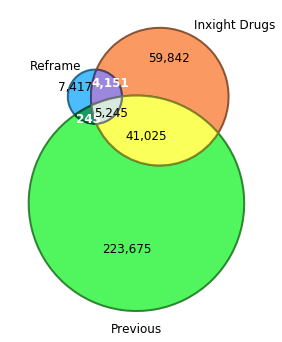

In [174]:
plt.figure(figsize=(10,6))
venn3_pretty([ref_ids, ix_ids, prev_ids], ['Reframe', 'Inxight Drugs', 'Previous'], border=False)

# Time to call in the big string manipulation guns...

In [175]:
import re
pattern = re.compile('[\W_]+')

def strip_chars(string):
    return pattern.sub('', string)

In [176]:
ref.columns

Index(['gvk_id', 'drug_name', 'phase', 'drug_roa', 'category', 'mechanism',
       'sub_smiles', 'synonyms_gvk', 'ikey', 'name_inf', 'highest_phase',
       'moa', 'target_name', 'target_family', 'origin', 'chem_name',
       'smiles_inf', 'key', 'pubchem', 'wikidata_inf', 'informa_id',
       'synonyms_inf', 'id', 'status', 'smiles_itg', 'name_itg',
       'integrity_note', 'int_thera_group', 'int_MoA', 'wikidata_itg',
       'PubChem CID', 'source', 'mesh_id', 'chebi_id', 'final_id'],
      dtype='object')

In [177]:
# chem_name seems dubious... urea was in one that was clearly not Urea...
name_cols = ['drug_name', 'synonyms_gvk', 'name_inf', 'synonyms_inf', 'name_itg']


name_set = []

for row in ref.itertuples():
    out = set()
    for col in name_cols:
        elem = getattr(row, col)
        if not pd.isnull(elem):
            out.update(set(elem.split('|')))
    name_set.append(set([strip_chars(o).lower() for o in out]))
ref['all_names'] = pd.Series(name_set)
ref.head(2)

,gvk_id,drug_name,phase,drug_roa,category,mechanism,sub_smiles,synonyms_gvk,ikey,name_inf,...,integrity_note,int_thera_group,int_MoA,wikidata_itg,PubChem CID,source,mesh_id,chebi_id,final_id,all_names
0,5916161.0,A-49816,Clinical Phase Unknown,NaN,High-Ceiling Diuretic,High-Ceiling Diuretic,Cl[H].[H]OC1=C(CN([H])[H])C=C(C=C1)C(=O)C2=CC=...,Abbott-49816,IKEY:WYFYYAHANZQLGG-UHFFFAOYSA-N,NaN,...,NaN,Diuretics,NaN,WD:Q27270440,CID92009045,gvk|integrity,NaN,NaN,IKEY:WYFYYAHANZQLGG-UHFFFAOYSA-N,"{a49816, abbott49816}"
1,5913712.0,Elmustine,Clinical Phase Unknown,NaN,Anticancer,Anticancer,[H]OCCN([H])C(=O)N(CCCl)N=O,BRN-1956525|FFC-33|HECNU|Hecnu|NSC-294895,IKEY:YJZJEQBSODVMTH-UHFFFAOYSA-N,Elmustine,...,NaN,Oncolytic Drugs,DNA-Damaging Drugs,WD:Q27284767,CID68804,gvk|informa|integrity,MESH:C013876,NaN,IKEY:YJZJEQBSODVMTH-UHFFFAOYSA-N,"{elmustine, brn1956525, ffc33, nsc294895, hecnu}"


In [178]:
ref['all_names'].apply(len).sum()

67172

In [179]:
expand_split_col(ref['all_names'])['all_names'].nunique()

60034

In [180]:
ref['all_names'] = ref['all_names'].apply(list)
ref_exp = expand_df_on_col(ref, 'all_names')
len(ref_exp)

67172

In [181]:
from collections import defaultdict

In [182]:
name_to_ikeys = defaultdict(set)
for name, df in ref_exp.groupby('all_names'):
    name_to_ikeys[name].update(set(df['ikey']))

In [183]:
len(name_to_ikeys)

60034

In [184]:
tups = [(k, len(v)) for k, v in name_to_ikeys.items()]
names = [t[0] for t in tups]
lens = [t[1] for t in tups]

In [185]:
name_len = pd.DataFrame({'names': names, 'lens': lens}).sort_values('lens', ascending=False)
name_len.head(10)

,names,lens
37495,noname,79
12242,ceftobiprolemedocaril,4
32265,m14659,4
47140,ro239424,4
26362,hp228,3
49519,seglitide,3
31314,lometrexol,3
34370,minopafant,3
19227,ebiratide,3
31890,lx2931,3


In [186]:
# Names belonging to more than one ikey
(name_len['lens'] > 1).sum()

6271

In [187]:
# names with fewer than 1 ikey
(name_len['lens'] == 1).sum()

53763

Group the ikeys....

# Make an adjcency list...

In [188]:
adj_list = defaultdict(set)
for row in ref_exp.itertuples():
    adj_list[row.ikey].add(row.final_id)
    adj_list[row.final_id].add(row.ikey)
    # Skip consolidation of nonames
    if row.all_names != 'noname':
        adj_list[row.final_id].add(row.all_names)
        adj_list[row.all_names].add(row.final_id)

Add in the other sources...

In [189]:
# Ensure all chebis are named
chebi_to_name = chebi.set_index('id')['name'].to_dict()
prev_comps['name'] = prev_comps['chebi_id'].map(chebi_to_name).fillna(prev_comps['name'])

In [190]:
# Add the network comps...
for row in prev_comps.dropna(subset=['name']).itertuples():
    
    adj_list[row.final_id].add(row.id)
    adj_list[row.id].add(row.final_id)
    
    if not pd.isnull(row.name):
        name = strip_chars(row.name).lower()
        adj_list[name].add(row.final_id)
        adj_list[row.final_id].add(name)

In [191]:
# Add all the inxight comps
for row in ix_comps.itertuples():
    adj_list[row.id].add(row.final_id)
    adj_list[row.final_id].add(row.id)
    
    if not pd.isnull(row.name):
        name = strip_chars(row.name).lower()

        adj_list[name].add(row.final_id)
        adj_list[row.final_id].add(name)

# Expand all the multiple IDs per line... in the inxight drugs
exp_ix_comps = ix_comps.copy()
for c in ix_comps.columns:
    exp_ix_comps = expand_col_on_char(exp_ix_comps, c, '|')
        

In [192]:
# Merge Uniis with names
archive = zipfile.ZipFile(data_dir.joinpath('UNIIs.zip'), 'r')
unii_names = pd.read_csv(archive.open('UNII NAMES 7Mar2019.txt'), sep='\t')
unii_names['UNII'] = 'UNII:' + unii_names['UNII']
    
ix_mrg = exp_ix_comps.merge(unii_names.dropna(subset=['Name']), how='inner', left_on='unii_id', right_on='UNII')

In [193]:
# Use the synonmyms...
for row in ix_mrg.itertuples():
    name = getattr(row, 'Name')
    if not pd.isnull(name):
        # Some names have superfulous info in a bracket... so strip it out...
        name = name.split('[')[0]
        
        name = strip_chars(name).lower()
        adj_list[name].add(row.final_id)
        adj_list[row.final_id].add(name)

In [194]:
from queue import Queue
from tqdm import tqdm

def get_subnets(input_adj_list):

    all_identifiers = list(input_adj_list.keys())

    subnets = defaultdict(set)
    visited = set()

    for net_id in tqdm(all_identifiers):
        if net_id not in visited:
            visited.add(net_id)
            q = Queue()
            q.put(net_id)

            while not q.empty():
                cur = q.get()
                visited.add(cur)

                for neighbour in input_adj_list[cur]:
                    subnets[net_id].add(neighbour)
                    if neighbour not in visited:
                        q.put(neighbour)
                        visited.add(neighbour)

    return subnets

In [195]:
subnets = get_subnets(adj_list)

100%|██████████| 1275617/1275617 [00:15<00:00, 83752.92it/s] 


In [196]:
len(subnets)

307940

In [197]:
# Get the special UNIIs
num_unii = unii_names.dropna()[unii_names.dropna()['UNII'].str.isnumeric()]['UNII'].unique()
alpha_unii = unii_names.dropna()[unii_names.dropna()['UNII'].str.isalpha()]['UNII'].unique()
SPECIAL_UNII = list(num_unii) + list(alpha_unii)    

In [198]:
def is_mesh(mid):
    return mid.startswith('MESH:')
def is_chebi(cid):
    return cid.startswith('CHEBI:')
def is_ikey(ikey):
    #return tuple(map(len, ikey.split('-'))) == (14, 10, 1)
    return ikey.startswith('IKEY:')
def is_drugbank(dbid):
    #return dbid.startswith('DB') and len(dbid) == 7
    return dbid.startswith('DB:')
def is_chembl(chemblid):
    return chemblid.startswith('CHEMBL:')

def is_pubchem(pcid):
    return pcid.startswith('PCID:')
def is_kegg(keggid):
    return keggid.startswith('KEGG:')
def is_umls(umls):
    return umls.startswith('UMLS:')
def is_wikidata(wiki):
    return wiki.startswith('WD:')


def is_unii(uid):
    
    """    
    old method for finding uniis, but now that we've added CURIs, shouldn't be necessary
    # The exact restructions on uniis are non-obvious other than length 10....
    if len(uid) != 10:
        return False
    # The uniis here are all capitalized on the alpha chars...
    if not uid.isupper():
        return False
    
    # Most UNIIs are mix of both alpha and numeric... 
    # Only a handful, of pure alpha, or pure num, so check if doesn't pass initial test...
    return (uid.isalnum() and not uid.isalpha() and not uid.isnumeric()) or uid in SPECIAL_UNII
    """
    return uid.startswith('UNII:')

def is_identifier(val):
    return is_mesh(val) or is_chebi(val) or is_chebi(val) or is_drugbank(val) or is_unii(val) or is_chembl(val) \
        or is_pubchem(val) or is_kegg(val) or is_umls(val) or is_wikidata(val)

In [199]:
def get_best_id(list_of_ids, pref_order=None):
    
    if pref_order is None:
        pref_order = ['chebi', 'ikey', 'unii', 'drugbank', 'mesh', 'chembl', 'pcid', 'kegg', 'umls', 'wd']
    
    # Ensure Types
    list_of_ids = list(list_of_ids)


    all_ids = dict()

    # Separate the IDs by type
    all_ids['mesh'] = [i for i in list_of_ids if is_mesh(i)]
    all_ids['chebi'] = [i for i in list_of_ids if is_chebi(i)]
    all_ids['ikey'] = [i for i in list_of_ids if is_ikey(i)]
    all_ids['drugbank'] = [i for i in list_of_ids if is_drugbank(i)]
    all_ids['unii'] = [i for i in list_of_ids if is_unii(i)]
    all_ids['chembl'] = [i for i in list_of_ids if is_chembl(i)]
    all_ids['pcid'] = [i for i in list_of_ids if is_pubchem(i)]
    all_ids['kegg'] = [i for i in list_of_ids if is_kegg(i)]
    all_ids['umls'] = [i for i in list_of_ids if is_umls(i)]
    all_ids['wd'] = [i for i in list_of_ids if is_wikidata(i)]
   
    
    # Find an id of the preferred type.
    for po in pref_order:
        if len(all_ids[po]) > 0:
            return all_ids[po][0]
    
    return list_of_ids[0]


In [200]:
id_to_subnet = {get_best_id(v): v for v in subnets.values()}
old_to_new_id = {v: k for k, vals in id_to_subnet.items() for v in vals}

In [201]:
len(id_to_subnet), len(old_to_new_id)

(307940, 1275617)

In [202]:
ref['final_id'] = ref['final_id'].map(old_to_new_id).fillna(ref['ikey'])
ref['final_id'].nunique()

12680

In [203]:
ref['final_id'].isnull().sum()

0

In [204]:
ix_comps['final_id'] = ix_comps['final_id'].map(old_to_new_id)
ix_comps['final_id'].nunique()

102528

In [205]:
ix_comps['final_id'].isnull().sum()

0

In [206]:
ix_comps[ix_comps['final_id'].isnull()].count()

name           0
label          0
chebi_id       0
chembl_id      0
drugbank_id    0
ikey           0
mesh_id        0
unii_id        0
source         0
id             0
final_id       0
dtype: int64

In [207]:
prev_comps['final_id'] = prev_comps['final_id'].map(old_to_new_id)
prev_comps['final_id'].nunique()

261609

In [208]:
prev_comps['final_id'].isnull().sum()

0

In [209]:
ref_ids = set(ref['final_id'])
ix_ids = set(ix_comps['final_id'])
prev_ids = set(prev_comps['final_id'])

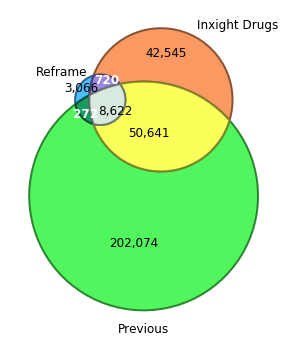

In [210]:
plt.figure(figsize=(10,6))
venn3_pretty([ref_ids, ix_ids, prev_ids], ['Reframe', 'Inxight Drugs', 'Previous'], border=False)

In the final network, we will keep everything expect the Orange region...


In [211]:
keep_ids = ref_ids & prev_ids

In [212]:
prev_comps.head(2)

,id,name,label,xrefs,curi,drugbank_id,mesh_id,chebi_id,final_id
0,CHEBI:10,(+)-Atherospermoline,Compound,CHEBI:10|CHEMBL:CHEMBL500609|KEGG:C11141|PCID:...,CHEBI,NaN,NaN,CHEBI:10,CHEBI:10
1,CHEBI:100,(-)-medicarpin,Compound,CHEBI:100|KEGG:C10503|PCID:336327|UNII:6TX086I6IG,CHEBI,NaN,NaN,CHEBI:100,CHEBI:100


In [213]:
ix_comps.head(2)

,name,label,chebi_id,chembl_id,drugbank_id,ikey,mesh_id,unii_id,source,id,final_id
0,Acetanilide,Compound,CHEBI:28884,CHEMBL:CHEMBL269644,NaN,IKEY:FZERHIULMFGESH-UHFFFAOYSA-N,MESH:C508827,UNII:SP86R356CC,ikey,IKEY:FZERHIULMFGESH-UHFFFAOYSA-N,CHEBI:31190
1,Acetylfuratrizine,Compound,CHEBI:135137,NaN,NaN,IKEY:SWMPGCCDXNLPED-NSCUHMNNSA-N,MESH:C007794,UNII:C50C4V19SU,ikey,IKEY:SWMPGCCDXNLPED-NSCUHMNNSA-N,CHEBI:135137


In [214]:
ref_nodes = ref.loc[:, ['final_id', 'source']]
ref_nodes['label'] = 'Drug'
prev_comp_nodes = prev_comps.loc[:, ['final_id', 'name', 'label']]
ix_comp_nodes = ix_comps.loc[:, ['final_id', 'name']].query('final_id in @keep_ids')
ix_comp_nodes['label'] = 'Drug'

In [215]:
compounds = pd.concat([ref_nodes, prev_comp_nodes, ix_comp_nodes], ignore_index=True, sort=False)
compounds = gt.order_cols(compounds.drop_duplicates(subset=['final_id'], keep='first').rename(columns={'final_id': 'id'}))

In [216]:
ref['name'] = ref['drug_name'].fillna(ref['name_inf'].fillna(ref['name_itg']))
id_to_name = chebi.set_index('id')['name'].to_dict()
id_to_name = {**chebi.set_index('mesh')['name'].to_dict(), **id_to_name}
id_to_name = {**chebi.set_index('ikey')['name'].to_dict(), **id_to_name}
id_to_name = {**prev_comps.set_index('id')['name'].to_dict(), **id_to_name}
id_to_name = {**ref.set_index('ikey')['name'].to_dict(), **id_to_name}
id_to_name = {**ref.set_index('mesh_id')['name'].to_dict(), **id_to_name}
id_to_name = {**ix_comps.set_index('id')['name'].to_dict(), **id_to_name}
id_to_name = {**ix_comps.set_index('ikey')['name'].to_dict(), **id_to_name}
id_to_name = {**ix_comps.set_index('unii_id')['name'].to_dict(), **id_to_name}

In [217]:
compounds['name'] = compounds['name'].fillna(compounds['id'].map(id_to_name))

In [218]:
compounds['label'].value_counts()

Compound    252715
Drug         12680
Name: label, dtype: int64

In [219]:
compounds['id'].apply(lambda s: s.split(':')[0]).value_counts().head(10)

CHEBI     87374
PCID      66548
WD        55763
IKEY      47116
CHEMBL     7382
UNII        888
DB          282
MESH         31
KEGG         10
UMLS          1
Name: id, dtype: int64

## Save out our gigantic mapping efforts

In [220]:
id_map_results = pd.DataFrame({'old_id': list(old_to_new_id.keys()), 'new_id': list(old_to_new_id.values())})

id_map_results['is_id'] = id_map_results['old_id'].apply(lambda x: is_identifier(x))
id_map_results['old_name'] = id_map_results['old_id'].map(id_to_name)
id_map_results['new_name'] = id_map_results['new_id'].map(id_to_name)

In [221]:
len(id_map_results)

1275617

In [222]:
max_res = id_map_results.query('is_id')['new_id'].value_counts().index[0]

In [223]:
id_map_results.query('new_id == @max_res and is_id')

,old_id,new_id,is_id,old_name,new_name
620331,UNII:33D0C5D77R,UNII:33D0C5D77R,True,Cetomacrogol 1000,Cetomacrogol 1000
620332,UNII:MK1889A3JS,UNII:33D0C5D77R,True,Cetomacrogol 1000,Cetomacrogol 1000
620334,UNII:G8K9HXI96S,UNII:33D0C5D77R,True,Cetomacrogol 1000,Cetomacrogol 1000
620335,UNII:W821XK704Z,UNII:33D0C5D77R,True,Cetomacrogol 1000,Cetomacrogol 1000
620342,UNII:XZ19O8Z6FM,UNII:33D0C5D77R,True,Cetomacrogol 1000,Cetomacrogol 1000
620349,UNII:5KLY4IOG20,UNII:33D0C5D77R,True,Cetomacrogol 1000,Cetomacrogol 1000
620354,UNII:0EV3Z43Y2I,UNII:33D0C5D77R,True,Cetomacrogol 1000,Cetomacrogol 1000
620355,UNII:GY15017H2B,UNII:33D0C5D77R,True,Cetomacrogol 1000,Cetomacrogol 1000
620360,UNII:6X446K7Q0Y,UNII:33D0C5D77R,True,Cetomacrogol 1000,Cetomacrogol 1000
620361,UNII:9E0067TYQH,UNII:33D0C5D77R,True,Cetomacrogol 1000,Cetomacrogol 1000


In [224]:
vc = id_map_results.query('is_id')['new_id'].value_counts()
high_val = vc[vc > 5].index

id_map_results.query('new_id in @high_val and is_id')

,old_id,new_id,is_id,old_name,new_name
58,CHEBI:72690,CHEBI:72690,True,pomalidomide,pomalidomide
87,UNII:4Z8R6ORS6L,CHEBI:72690,True,Thalidomide,pomalidomide
95,UNII:F0P408N6V4,CHEBI:72690,True,Lenalidomide,pomalidomide
99,CHEBI:74947,CHEBI:72690,True,"2-(2,6-dioxopiperidin-3-yl)-1H-isoindole-1,3(2...",pomalidomide
100,CHEBI:61918,CHEBI:72690,True,(S)-thalidomide,pomalidomide
...,...,...,...,...,...
1021295,UNII:V9BQI51YUL,IKEY:DQXBYHZEEUGOBF-UHFFFAOYSA-N,True,Ethylene-vinyl acetate copolymer (15% vinyl ac...,Ethylene-vinyl acetate copolymer (19% vinylace...
1021297,UNII:3H390O24SI,IKEY:DQXBYHZEEUGOBF-UHFFFAOYSA-N,True,Ethylene-vinyl acetate copolymer (50% vinyl ac...,Ethylene-vinyl acetate copolymer (19% vinylace...
1021300,UNII:4OKC630HS6,IKEY:DQXBYHZEEUGOBF-UHFFFAOYSA-N,True,Ethylene-vinyl acetate copolymer (9% vinylacet...,Ethylene-vinyl acetate copolymer (19% vinylace...
1021307,UNII:8ILA5X28VS,IKEY:DQXBYHZEEUGOBF-UHFFFAOYSA-N,True,Ethylene-vinyl acetate copolymer (28% vinyl ac...,Ethylene-vinyl acetate copolymer (19% vinylace...


In [225]:
len(high_val)

224

In [226]:
id_map_results.to_csv(out_dir.joinpath('compound_identifier_mapping.csv'), index=False)
compounds.to_csv(out_dir.joinpath('compound_nodes.csv'), index=False)

In [227]:
id_to_xrefs = combine_group_cols_on_char(id_map_results, ['new_id'], ['old_id'], sort=True, prog=False)
id_to_xrefs = id_to_xrefs.set_index('new_id')['old_id'].to_dict()

In [228]:
compounds['xrefs'] = compounds['id'].map(id_to_xrefs)

In [229]:
compounds.sample(10)

,id,name,label,source,xrefs
172487,PCID:56843431,"(3S,4S,5S)-3-(ethylamino)-4,5-dihydroxy-6-[[(1...",Compound,NaN,3s4s5s3ethylamino45dihydroxy61s13s8hydroxy1oxo...
116527,IKEY:PDJZASCRQRBYQS-UHFFFAOYSA-N,N-BENZYL-4-[4-(3-CHLOROPHENYL)-1H-PYRAZOL-3-YL...,Compound,NaN,CHEMBL:CHEMBL220320|IKEY:PDJZASCRQRBYQS-UHFFFA...
33135,CHEBI:115748,6-ethyl-N-[2-(4-methoxyphenyl)ethyl]-5-methyl-...,Compound,NaN,6ethyln24methoxyphenylethyl5methyl124triazolo1...
30916,CHEBI:113541,2-phenyl-1H-indole,Compound,NaN,1hindole2phenyl|2phenyl1hindole|2phenylindole|...
6637,CHEBI:48095,keto-D-fructose,Drug,gvk,CHEBI:15824|CHEBI:28757|CHEBI:43703|CHEBI:4809...
36568,CHEBI:119163,"N-[(2S,3R,6S)-6-[2-(2,3-dihydro-1H-inden-2-yla...",Compound,NaN,CHEBI:119163|n2s3r6s6223dihydro1hinden2ylamino...
137128,PCID:131754200,[(2S)-2-octadecanoyloxy-3-pentadecanoyloxyprop...,Compound,NaN,2s2octadecanoyloxy3pentadecanoyloxypropyl8z11z...
46777,CHEBI:129354,LSM-40905,Compound,NaN,CHEBI:129354|lsm40905
259837,WD:Q72474452,3-Fluoro-5-methylbenzoic acid,Compound,NaN,3fluoro5methylbenzoicacid|WD:Q72474452
273025,IKEY:IMAKHNTVDGLIRY-UHFFFAOYSA-N,Methyl propiolate,Compound,NaN,2propynoicacidmethylester|IKEY:IMAKHNTVDGLIRY-...


## Integrate the results of this mapping effort to the network

In [230]:
prev_nodes = pd.read_csv('../2_pipeline/07a_NCATS_Inxight_Drugs_DB_and_DC/out/nodes.csv', dtype=str)
prev_edges = pd.read_csv('../2_pipeline/07a_NCATS_Inxight_Drugs_DB_and_DC/out/edges.csv', dtype=str)

In [231]:
prev_nodes['id'] = prev_nodes['id'].apply(lambda i: ix_comp_id_map.get(i, i))

In [232]:
prev_edges['start_id'] = prev_edges['start_id'].apply(lambda i: ix_comp_id_map.get(i, i))
prev_edges['end_id'] = prev_edges['end_id'].apply(lambda i: ix_comp_id_map.get(i, i))

In [233]:
former_comps = prev_nodes.query('label == "Compound"')['id'].unique()
id_mapper = {k: old_to_new_id[k] for k in former_comps}

In [234]:
len(old_to_new_id), len(id_mapper)

(1275617, 374382)

In [235]:
# compounds have some added info we'll add in, so lets remove their original vesion
new_comp_ids = compounds['id'].unique()
prev_nodes = prev_nodes.query('id not in @new_comp_ids').reset_index(drop=True)
# Also drop the chemical specific columns
prev_nodes = prev_nodes.iloc[:, :4]
prev_nodes.head(2)

,id,name,label,xrefs
0,UBERON:0000002,cervix,Anatomy,MESH:D002584|UBERON:0000002
1,UBERON:0000004,human nose,Anatomy,MESH:D009666|UBERON:0000004


In [236]:
prev_comp_idx = prev_nodes.query('label == "Compound"').index
len(prev_comp_idx)

127020

In [237]:
prev_edges['source'].value_counts()

Gene Ontology                         1160861
WikiData                               981076
Reactome                               869043
Gene Ontology|WikiData                 276894
Human Phenotype Ontology               222957
miRTarBase                              94641
Protein Ontology                        74360
Inxight Drugs                           61661
Gene Ontology|Reactome|WikiData         32121
ensembl                                 28426
InterPro                                27019
DrugBank                                10048
DrugCentral                              9114
Reactome|WikiData                        7201
Protein Ontology|ensembel                4494
UBERON                                   1647
Cell Ontology                            1581
ComplexPortal                            1394
Human Phenotype Ontology|WikiData         981
DrugBank|DrugCentral|Inxight Drugs        760
ComplexPortal|Reactome                    661
DrugCentral|Inxight Drugs         

In [238]:
prev_nodes.query('label == "Compound" ')['id'].nunique()

120961

In [239]:
prev_nodes.loc[prev_comp_idx, 'id'].map(id_mapper).nunique()

103258

In [240]:
prev_nodes.loc[prev_comp_idx, 'id'].map(id_mapper).count()

127020

In [241]:
nodes_out = pd.concat([prev_nodes.drop(prev_comp_idx), compounds], ignore_index=True, sort=False)

In [242]:
edges_out = prev_edges.copy()
edges_out['start_id'] = edges_out['start_id'].map(id_mapper).fillna(edges_out['start_id'])
edges_out['end_id'] = edges_out['end_id'].map(id_mapper).fillna(edges_out['end_id'])

In [243]:
node_ids = nodes_out['id'].unique()

In [244]:
print('{:,}'.format(len(edges_out)))
edges_out = edges_out.query('start_id in @node_ids and end_id in @node_ids').copy()
print('{:,}'.format(len(edges_out)))

3,868,544
3,863,150


In [245]:
dup_cols = ['start_id', 'end_id', 'type']
print('{:,}'.format(edges_out.duplicated(subset=dup_cols, keep=False).sum()))

28,436


In [246]:
edges_out.columns

Index(['start_id', 'end_id', 'type', 'dsrc_type', 'comp_type', 'p_val',
       'adj_p', 'source', 'license', 'experiments', 'support_type', 'pmids',
       'phase', 'date'],
      dtype='object')

In [247]:
%%time

edges_out = combine_group_cols_on_char(edges_out, ['start_id', 'end_id', 'type'], sort=True, prog=False)


CPU times: user 13.5 s, sys: 1.1 s, total: 14.6 s
Wall time: 14.6 s


In [248]:
len(edges_out)

3847653

In [249]:
nodes_out.query('label == "Drug"').shape

(12680, 5)

In [250]:
edges_out['source'].value_counts()

Gene Ontology                                  1159055
WikiData                                        978981
Reactome                                        866727
Gene Ontology|WikiData                          276894
Human Phenotype Ontology                        222957
miRTarBase                                       94641
Protein Ontology                                 74360
Inxight Drugs                                    47321
Gene Ontology|Reactome|WikiData                  32121
ensembl                                          28426
InterPro                                         27019
DrugBank                                          9302
DrugCentral                                       8946
Reactome|WikiData                                 7201
Protein Ontology|ensembel                         4494
UBERON                                            1647
Cell Ontology                                     1581
ComplexPortal                                     1394
Human Phen

In [251]:
edge_ids = edges_out[['start_id', 'end_id']].stack().unique()
nodes_filt = nodes_out.query('id in @edge_ids')

In [252]:
len(edge_ids)

385626

In [253]:
len(nodes_out), len(nodes_filt)

(784439, 385626)

In [254]:
nodes_out.to_csv(out_dir.joinpath('nodes.csv'), index=False)
nodes_filt.to_csv(out_dir.joinpath('nodes_filt.csv'), index=False)
edges_out.to_csv(out_dir.joinpath('edges.csv'), index=False)